# Library imports, setup

In [1]:
#if you change a file, you dont have to restart the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from data import load_metadata, visualize_data, make_dataset
from model import build_multitask_model
from score_metrics import get_scores
from loss import SoftF1Loss #custom loss function, currently not used

2025-12-01 22:16:23.047033: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 22:16:23.224080: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 22:16:24.511623: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# check tf version
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    tf.config.experimental.set_memory_growth(device, True)
    print(f"Found GPU {device.name}, and set memory growth to True.")

2.20.0
Found GPU /physical_device:GPU:0, and set memory growth to True.


# Loading data

In [4]:
image_metadata, species_metadata = load_metadata()
NUM_SPECIES = len(species_metadata)

Number of classes: 296


/mnt/d/Egyetem_adat/kigyo2/snek/src/Models/data.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["encoded_id"] = encoder.fit_transform(image_metadata["class_id"])
/mnt/d/Egyetem_adat/kigyo2/snek/src/Models/data.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_metadata["image_path"] = image_metadata["image_path"].apply(


# Visualizing data

In [5]:
#in data.py
#visualize_data(image_metadata)

Loading python images from folder

# Building model

In [6]:
import tensorflow as tf
import keras

In [7]:
from model import build_multitask_model
from score_metrics import get_scores
from loss import SoftF1Loss 

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
#IMAGE_RESOLUTION=224
IMAGE_RESOLUTION=544

NUM_FOLDS = 3


from data import make_batches



X_paths = image_metadata["image_path"].values
y_species = image_metadata["encoded_id"].values

skf = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=42,
)

fold_metrics = []

best_fold_idx = None
best_macro_f1 = -np.inf

all_y_species_true = []
all_y_species_pred = []
all_y_venom_true = []
all_y_venom_pred = []

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_paths, y_species), start=1):
    print(f"\n===== FOLD {fold_idx}/{NUM_FOLDS} =====")

    train_info = image_metadata.iloc[train_idx].copy()
    val_info   = image_metadata.iloc[val_idx].copy()

    # --- class weight csak a trainre számolva ---
    species_classes = np.unique(train_info["encoded_id"])
    species_cw = compute_class_weight(
        class_weight="balanced",
        classes=species_classes,
        y=train_info["encoded_id"],
    )
    species_cw_dict = {int(c): w for c, w in zip(species_classes, species_cw)}

    species_weight_vec = tf.constant(
        [species_cw_dict[i] for i in range(len(species_cw_dict))],
        dtype=tf.float32,
    )

    # --- tf.data datasetek ---
    train_dataset = make_batches(
        train_info,
        IMAGE_RESOLUTION,
        species_weight_vec=species_weight_vec,
    )

    val_dataset = make_batches(
        val_info,
        IMAGE_RESOLUTION,
        species_weight_vec=None,
    )

    # --- modell: minden foldban újraépítjük ---
    model = build_multitask_model(
        num_species=NUM_SPECIES,
        image_resolution=IMAGE_RESOLUTION,
    )

    lr = 1e-4  # EfficientNetB0-hoz alacsony LR

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=[
            tf.keras.losses.SparseCategoricalCrossentropy(),
            "binary_crossentropy",
        ],
        loss_weights=[1.0, 0.5],
        metrics=["accuracy", "accuracy"],
    )

    # --- callbackek fold-specifikus checkpointtal ---
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"best_model_fold{fold_idx}.keras",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    )

    early_stop_cb = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True,
        verbose=1,
    )

    reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1,
    )

    n_epochs = 50

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=n_epochs,
        callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb],
    )

    # --- saját metrikák foldonként, get_scores-szal ---
    metrics_fold = get_scores(
        model,
        image_metadata=image_metadata,
        test_dataset=val_dataset,
        venom_threshold=0.5,
    )

    fold_metrics.append(metrics_fold)

    if metrics_fold["macro_f1"] > best_macro_f1:
        best_macro_f1 = metrics_fold["macro_f1"]
        best_fold_idx = fold_idx

    
    all_y_species_true.append(metrics_fold["y_species_true"])
    all_y_species_pred.append(metrics_fold["y_species_pred"])
    all_y_venom_true.append(metrics_fold["y_venom_true"])
    all_y_venom_pred.append(metrics_fold["y_venom_pred"])

# --- aggregált CV-eredmények (átlag metrikák + összesített predikciók) ---

best_model = keras.models.load_model(
    f"best_model_fold{best_fold_idx}.keras",
    custom_objects={"SoftF1Loss": SoftF1Loss},
)
best_model.save("final_cv_model.keras")

results_own_metrics = {
    "species_accuracy": np.mean([m["species_accuracy"] for m in fold_metrics]),
    "macro_f1": np.mean([m["macro_f1"] for m in fold_metrics]),
    "venom_accuracy": np.mean([m["venom_accuracy"] for m in fold_metrics]),
    "venom_weighted_species_accuracy": np.mean(
        [m["venom_weighted_species_accuracy"] for m in fold_metrics]
    ),
    "y_species_true": np.concatenate(all_y_species_true, axis=0),
    "y_species_pred": np.concatenate(all_y_species_pred, axis=0),
    "y_venom_true": np.concatenate(all_y_venom_true, axis=0),
    "y_venom_pred": np.concatenate(all_y_venom_pred, axis=0),
}

print("\n=== Átlagolt keresztvalidációs eredmények ===")
print(f"Species accuracy (val): {results_own_metrics['species_accuracy']:.4f}")
print(f"Macro-F1 (species, val): {results_own_metrics['macro_f1']:.4f}")
print(f"Venom accuracy (val): {results_own_metrics['venom_accuracy']:.4f}")
print(
    "Venom-weighted species accuracy (val): "
    f"{results_own_metrics['venom_weighted_species_accuracy']:.4f}"
)


I0000 00:00:1764623786.290937    2181 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9



===== FOLD 1/3 =====
Epoch 1/50


2025-12-01 22:16:36.115202: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


 261/1385 ━━━━━━━━━━━━━━━━━━━━ 8:25 450ms/step - loss: 5.9670 - species_accuracy: 0.0047 - species_loss: 5.7195 - venom_accuracy: 0.8017 - venom_loss: 0.4950

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 627/1385 ━━━━━━━━━━━━━━━━━━━━ 5:45 456ms/step - loss: 5.8678 - species_accuracy: 0.0117 - species_loss: 5.6325 - venom_accuracy: 0.8079 - venom_loss: 0.4706

2025-12-01 22:21:26.013381: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 5.6696 - species_accuracy: 0.0274 - species_loss: 5.4447 - venom_accuracy: 0.8129 - venom_loss: 0.4498
Epoch 1: val_loss improved from None to 4.48247, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 954s 681ms/step - loss: 5.3118 - species_accuracy: 0.0542 - species_loss: 5.0984 - venom_accuracy: 0.8183 - venom_loss: 0.4260 - val_loss: 4.4825 - val_species_accuracy: 0.1487 - val_species_loss: 4.2942 - val_venom_accuracy: 0.8405 - val_venom_loss: 0.3770 - learning_rate: 1.0000e-04
Epoch 2/50
 492/1385 ━━━━━━━━━━━━━━━━━━━━ 6:58 469ms/step - loss: 4.5402 - species_accuracy: 0.1085 - species_loss: 4.3395 - venom_accuracy: 0.8280 - venom_loss: 0.4014

2025-12-01 22:36:13.935922: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 591/1385 ━━━━━━━━━━━━━━━━━━━━ 6:11 467ms/step - loss: 4.5312 - species_accuracy: 0.1101 - species_loss: 4.3300 - venom_accuracy: 0.8274 - venom_loss: 0.4024

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 4.4404 - species_accuracy: 0.1200 - species_loss: 4.2383 - venom_accuracy: 0.8267 - venom_loss: 0.4040
Epoch 2: val_loss improved from 4.48247 to 3.89737, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 949s 685ms/step - loss: 4.2937 - species_accuracy: 0.1348 - species_loss: 4.0922 - venom_accuracy: 0.8278 - venom_loss: 0.4023 - val_loss: 3.8974 - val_species_accuracy: 0.2145 - val_species_loss: 3.7163 - val_venom_accuracy: 0.8451 - val_venom_loss: 0.3632 - learning_rate: 1.0000e-04
Epoch 3/50
  40/1385 ━━━━━━━━━━━━━━━━━━━━ 11:03 493ms/step - loss: 3.9385 - species_accuracy: 0.1902 - species_loss: 3.7412 - venom_accuracy: 0.8254 - venom_loss: 0.3946

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 328/1385 ━━━━━━━━━━━━━━━━━━━━ 8:02 457ms/step - loss: 3.9437 - species_accuracy: 0.1775 - species_loss: 3.7439 - venom_accuracy: 0.8284 - venom_loss: 0.3996

2025-12-01 22:50:41.808840: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 3.9173 - species_accuracy: 0.1784 - species_loss: 3.7193 - venom_accuracy: 0.8291 - venom_loss: 0.3960
Epoch 3: val_loss improved from 3.89737 to 3.59008, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 3.8712 - species_accuracy: 0.1829 - species_loss: 3.6752 - venom_accuracy: 0.8312 - venom_loss: 0.3921 - val_loss: 3.5901 - val_species_accuracy: 0.2541 - val_species_loss: 3.4129 - val_venom_accuracy: 0.8501 - val_venom_loss: 0.3542 - learning_rate: 1.0000e-04
Epoch 4/50
  34/1385 ━━━━━━━━━━━━━━━━━━━━ 11:14 499ms/step - loss: 3.9154 - species_accuracy: 0.1846 - species_loss: 3.7203 - venom_accuracy: 0.8321 - venom_loss: 0.3903

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 987/1385 ━━━━━━━━━━━━━━━━━━━━ 2:59 450ms/step - loss: 3.6675 - species_accuracy: 0.2097 - species_loss: 3.4703 - venom_accuracy: 0.8307 - venom_loss: 0.3944

2025-12-01 23:10:51.612732: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 3.6542 - species_accuracy: 0.2117 - species_loss: 3.4578 - venom_accuracy: 0.8313 - venom_loss: 0.3927
Epoch 4: val_loss improved from 3.59008 to 3.43189, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 3.6116 - species_accuracy: 0.2174 - species_loss: 3.4177 - venom_accuracy: 0.8335 - venom_loss: 0.3865 - val_loss: 3.4319 - val_species_accuracy: 0.2761 - val_species_loss: 3.2554 - val_venom_accuracy: 0.8503 - val_venom_loss: 0.3527 - learning_rate: 1.0000e-04
Epoch 5/50
 193/1385 ━━━━━━━━━━━━━━━━━━━━ 9:06 458ms/step - loss: 3.5065 - species_accuracy: 0.2191 - species_loss: 3.3242 - venom_accuracy: 0.8467 - venom_loss: 0.3647

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 798/1385 ━━━━━━━━━━━━━━━━━━━━ 4:25 452ms/step - loss: 3.4818 - species_accuracy: 0.2317 - species_loss: 3.2939 - venom_accuracy: 0.8388 - venom_loss: 0.3757

2025-12-01 23:24:42.473156: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 3.4614 - species_accuracy: 0.2366 - species_loss: 3.2724 - venom_accuracy: 0.8374 - venom_loss: 0.3779
Epoch 5: val_loss improved from 3.43189 to 3.29341, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 660ms/step - loss: 3.4276 - species_accuracy: 0.2437 - species_loss: 3.2366 - venom_accuracy: 0.8354 - venom_loss: 0.3809 - val_loss: 3.2934 - val_species_accuracy: 0.2959 - val_species_loss: 3.1213 - val_venom_accuracy: 0.8530 - val_venom_loss: 0.3455 - learning_rate: 1.0000e-04
Epoch 6/50
 835/1385 ━━━━━━━━━━━━━━━━━━━━ 4:07 451ms/step - loss: 3.2834 - species_accuracy: 0.2613 - species_loss: 3.0957 - venom_accuracy: 0.8412 - venom_loss: 0.3753

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 908/1385 ━━━━━━━━━━━━━━━━━━━━ 3:35 451ms/step - loss: 3.2835 - species_accuracy: 0.2612 - species_loss: 3.0960 - venom_accuracy: 0.8413 - venom_loss: 0.3750

2025-12-01 23:40:45.453536: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 3.2835 - species_accuracy: 0.2615 - species_loss: 3.0962 - venom_accuracy: 0.8410 - venom_loss: 0.3744
Epoch 6: val_loss improved from 3.29341 to 3.21396, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 661ms/step - loss: 3.2822 - species_accuracy: 0.2627 - species_loss: 3.0952 - venom_accuracy: 0.8406 - venom_loss: 0.3741 - val_loss: 3.2140 - val_species_accuracy: 0.3086 - val_species_loss: 3.0425 - val_venom_accuracy: 0.8554 - val_venom_loss: 0.3437 - learning_rate: 1.0000e-04
Epoch 7/50
 224/1385 ━━━━━━━━━━━━━━━━━━━━ 8:44 452ms/step - loss: 3.0870 - species_accuracy: 0.2892 - species_loss: 2.9067 - venom_accuracy: 0.8444 - venom_loss: 0.3605

2025-12-01 23:50:52.173674: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 971/1385 ━━━━━━━━━━━━━━━━━━━━ 3:06 451ms/step - loss: 3.1473 - species_accuracy: 0.2851 - species_loss: 2.9631 - venom_accuracy: 0.8410 - venom_loss: 0.3684

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 3.1559 - species_accuracy: 0.2839 - species_loss: 2.9712 - venom_accuracy: 0.8406 - venom_loss: 0.3694
Epoch 7: val_loss improved from 3.21396 to 3.11381, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 661ms/step - loss: 3.1715 - species_accuracy: 0.2805 - species_loss: 2.9860 - venom_accuracy: 0.8402 - venom_loss: 0.3703 - val_loss: 3.1138 - val_species_accuracy: 0.3251 - val_species_loss: 2.9429 - val_venom_accuracy: 0.8555 - val_venom_loss: 0.3414 - learning_rate: 1.0000e-04
Epoch 8/50
 441/1385 ━━━━━━━━━━━━━━━━━━━━ 7:06 451ms/step - loss: 3.1043 - species_accuracy: 0.2918 - species_loss: 2.9201 - venom_accuracy: 0.8423 - venom_loss: 0.3683

2025-12-02 00:07:44.811694: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 981/1385 ━━━━━━━━━━━━━━━━━━━━ 3:02 453ms/step - loss: 3.0809 - species_accuracy: 0.2955 - species_loss: 2.8969 - venom_accuracy: 0.8420 - venom_loss: 0.3680

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 3.0732 - species_accuracy: 0.2964 - species_loss: 2.8890 - venom_accuracy: 0.8417 - venom_loss: 0.3684
Epoch 8: val_loss improved from 3.11381 to 3.05456, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 920s 665ms/step - loss: 3.0525 - species_accuracy: 0.2983 - species_loss: 2.8676 - venom_accuracy: 0.8411 - venom_loss: 0.3693 - val_loss: 3.0546 - val_species_accuracy: 0.3353 - val_species_loss: 2.8844 - val_venom_accuracy: 0.8549 - val_venom_loss: 0.3430 - learning_rate: 1.0000e-04
Epoch 9/50
 295/1385 ━━━━━━━━━━━━━━━━━━━━ 8:01 441ms/step - loss: 2.9182 - species_accuracy: 0.3088 - species_loss: 2.7415 - venom_accuracy: 0.8476 - venom_loss: 0.3533

2025-12-02 00:21:56.406492: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 929/1385 ━━━━━━━━━━━━━━━━━━━━ 3:23 446ms/step - loss: 2.9548 - species_accuracy: 0.3103 - species_loss: 2.7758 - venom_accuracy: 0.8466 - venom_loss: 0.3581

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 2.9623 - species_accuracy: 0.3107 - species_loss: 2.7824 - venom_accuracy: 0.8462 - venom_loss: 0.3598
Epoch 9: val_loss improved from 3.05456 to 2.99309, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 2.9724 - species_accuracy: 0.3112 - species_loss: 2.7904 - venom_accuracy: 0.8446 - venom_loss: 0.3637 - val_loss: 2.9931 - val_species_accuracy: 0.3462 - val_species_loss: 2.8232 - val_venom_accuracy: 0.8567 - val_venom_loss: 0.3381 - learning_rate: 1.0000e-04
Epoch 10/50
 330/1385 ━━━━━━━━━━━━━━━━━━━━ 7:51 447ms/step - loss: 2.8734 - species_accuracy: 0.3284 - species_loss: 2.6888 - venom_accuracy: 0.8388 - venom_loss: 0.3692

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 423/1385 ━━━━━━━━━━━━━━━━━━━━ 7:08 446ms/step - loss: 2.8713 - species_accuracy: 0.3279 - species_loss: 2.6874 - venom_accuracy: 0.8398 - venom_loss: 0.3678

2025-12-02 00:38:08.457059: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 2.8817 - species_accuracy: 0.3256 - species_loss: 2.6990 - venom_accuracy: 0.8425 - venom_loss: 0.3654
Epoch 10: val_loss improved from 2.99309 to 2.95285, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 661ms/step - loss: 2.8906 - species_accuracy: 0.3248 - species_loss: 2.7082 - venom_accuracy: 0.8432 - venom_loss: 0.3643 - val_loss: 2.9528 - val_species_accuracy: 0.3522 - val_species_loss: 2.7832 - val_venom_accuracy: 0.8569 - val_venom_loss: 0.3378 - learning_rate: 1.0000e-04
Epoch 11/50
  49/1385 ━━━━━━━━━━━━━━━━━━━━ 9:09 411ms/step - loss: 2.7119 - species_accuracy: 0.3519 - species_loss: 2.5356 - venom_accuracy: 0.8724 - venom_loss: 0.3527

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 202/1385 ━━━━━━━━━━━━━━━━━━━━ 8:40 440ms/step - loss: 2.7953 - species_accuracy: 0.3430 - species_loss: 2.6143 - venom_accuracy: 0.8558 - venom_loss: 0.3620

2025-12-02 00:51:43.653364: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 2.8221 - species_accuracy: 0.3381 - species_loss: 2.6415 - venom_accuracy: 0.8471 - venom_loss: 0.3613
Epoch 11: val_loss improved from 2.95285 to 2.92092, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 911s 658ms/step - loss: 2.8192 - species_accuracy: 0.3385 - species_loss: 2.6389 - venom_accuracy: 0.8455 - venom_loss: 0.3604 - val_loss: 2.9209 - val_species_accuracy: 0.3554 - val_species_loss: 2.7527 - val_venom_accuracy: 0.8570 - val_venom_loss: 0.3367 - learning_rate: 1.0000e-04
Epoch 12/50
 559/1385 ━━━━━━━━━━━━━━━━━━━━ 6:09 448ms/step - loss: 2.7199 - species_accuracy: 0.3548 - species_loss: 2.5402 - venom_accuracy: 0.8490 - venom_loss: 0.3595

2025-12-02 01:09:38.770133: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 635/1385 ━━━━━━━━━━━━━━━━━━━━ 5:35 448ms/step - loss: 2.7201 - species_accuracy: 0.3543 - species_loss: 2.5403 - venom_accuracy: 0.8488 - venom_loss: 0.3595

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 2.7252 - species_accuracy: 0.3519 - species_loss: 2.5461 - venom_accuracy: 0.8483 - venom_loss: 0.3581
Epoch 12: val_loss improved from 2.92092 to 2.88654, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 918s 660ms/step - loss: 2.7406 - species_accuracy: 0.3495 - species_loss: 2.5624 - venom_accuracy: 0.8477 - venom_loss: 0.3561 - val_loss: 2.8865 - val_species_accuracy: 0.3596 - val_species_loss: 2.7195 - val_venom_accuracy: 0.8589 - val_venom_loss: 0.3341 - learning_rate: 1.0000e-04
Epoch 13/50
 496/1385 ━━━━━━━━━━━━━━━━━━━━ 6:37 447ms/step - loss: 2.6739 - species_accuracy: 0.3628 - species_loss: 2.4912 - venom_accuracy: 0.8411 - venom_loss: 0.3653

2025-12-02 01:24:24.933707: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 614/1385 ━━━━━━━━━━━━━━━━━━━━ 5:43 445ms/step - loss: 2.6745 - species_accuracy: 0.3627 - species_loss: 2.4928 - venom_accuracy: 0.8421 - venom_loss: 0.3635

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 2.6757 - species_accuracy: 0.3620 - species_loss: 2.4956 - venom_accuracy: 0.8440 - venom_loss: 0.3600
Epoch 13: val_loss improved from 2.88654 to 2.85691, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 911s 658ms/step - loss: 2.6821 - species_accuracy: 0.3599 - species_loss: 2.5048 - venom_accuracy: 0.8467 - venom_loss: 0.3558 - val_loss: 2.8569 - val_species_accuracy: 0.3652 - val_species_loss: 2.6907 - val_venom_accuracy: 0.8601 - val_venom_loss: 0.3314 - learning_rate: 1.0000e-04
Epoch 14/50
 623/1385 ━━━━━━━━━━━━━━━━━━━━ 5:38 444ms/step - loss: 2.5754 - species_accuracy: 0.3802 - species_loss: 2.4032 - venom_accuracy: 0.8544 - venom_loss: 0.3444

2025-12-02 01:40:34.395108: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1006/1385 ━━━━━━━━━━━━━━━━━━━━ 2:49 446ms/step - loss: 2.5898 - species_accuracy: 0.3781 - species_loss: 2.4162 - venom_accuracy: 0.8525 - venom_loss: 0.3472

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 2.5991 - species_accuracy: 0.3763 - species_loss: 2.4245 - venom_accuracy: 0.8516 - venom_loss: 0.3491
Epoch 14: val_loss improved from 2.85691 to 2.83133, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 658ms/step - loss: 2.6271 - species_accuracy: 0.3713 - species_loss: 2.4500 - venom_accuracy: 0.8496 - venom_loss: 0.3539 - val_loss: 2.8313 - val_species_accuracy: 0.3678 - val_species_loss: 2.6643 - val_venom_accuracy: 0.8597 - val_venom_loss: 0.3332 - learning_rate: 1.0000e-04
Epoch 15/50
 377/1385 ━━━━━━━━━━━━━━━━━━━━ 7:33 450ms/step - loss: 2.5306 - species_accuracy: 0.3801 - species_loss: 2.3503 - venom_accuracy: 0.8444 - venom_loss: 0.3606

2025-12-02 01:53:58.192563: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 619/1385 ━━━━━━━━━━━━━━━━━━━━ 5:43 449ms/step - loss: 2.5419 - species_accuracy: 0.3813 - species_loss: 2.3632 - venom_accuracy: 0.8459 - venom_loss: 0.3573

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.5546 - species_accuracy: 0.3804 - species_loss: 2.3777 - venom_accuracy: 0.8478 - venom_loss: 0.3538
Epoch 15: val_loss improved from 2.83133 to 2.78434, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 2.5753 - species_accuracy: 0.3777 - species_loss: 2.3992 - venom_accuracy: 0.8487 - venom_loss: 0.3526 - val_loss: 2.7843 - val_species_accuracy: 0.3793 - val_species_loss: 2.6191 - val_venom_accuracy: 0.8613 - val_venom_loss: 0.3290 - learning_rate: 1.0000e-04
Epoch 16/50
  80/1385 ━━━━━━━━━━━━━━━━━━━━ 9:45 448ms/step - loss: 2.5119 - species_accuracy: 0.4003 - species_loss: 2.3228 - venom_accuracy: 0.8324 - venom_loss: 0.3783

2025-12-02 02:06:58.032497: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 732/1385 ━━━━━━━━━━━━━━━━━━━━ 4:55 453ms/step - loss: 2.5178 - species_accuracy: 0.3925 - species_loss: 2.3375 - venom_accuracy: 0.8437 - venom_loss: 0.3605

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.5232 - species_accuracy: 0.3905 - species_loss: 2.3447 - venom_accuracy: 0.8458 - venom_loss: 0.3571
Epoch 16: val_loss improved from 2.78434 to 2.77441, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 661ms/step - loss: 2.5206 - species_accuracy: 0.3909 - species_loss: 2.3442 - venom_accuracy: 0.8489 - venom_loss: 0.3526 - val_loss: 2.7744 - val_species_accuracy: 0.3805 - val_species_loss: 2.6092 - val_venom_accuracy: 0.8603 - val_venom_loss: 0.3304 - learning_rate: 1.0000e-04
Epoch 17/50
 700/1385 ━━━━━━━━━━━━━━━━━━━━ 5:07 449ms/step - loss: 2.4699 - species_accuracy: 0.4002 - species_loss: 2.2931 - venom_accuracy: 0.8456 - venom_loss: 0.3537

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1289/1385 ━━━━━━━━━━━━━━━━━━━━ 43s 450ms/step - loss: 2.4731 - species_accuracy: 0.3985 - species_loss: 2.2967 - venom_accuracy: 0.8474 - venom_loss: 0.3528

2025-12-02 02:31:16.587118: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.4733 - species_accuracy: 0.3984 - species_loss: 2.2969 - venom_accuracy: 0.8476 - venom_loss: 0.3527
Epoch 17: val_loss improved from 2.77441 to 2.75462, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 913s 660ms/step - loss: 2.4740 - species_accuracy: 0.3968 - species_loss: 2.2983 - venom_accuracy: 0.8501 - venom_loss: 0.3506 - val_loss: 2.7546 - val_species_accuracy: 0.3841 - val_species_loss: 2.5910 - val_venom_accuracy: 0.8611 - val_venom_loss: 0.3280 - learning_rate: 1.0000e-04
Epoch 18/50
 481/1385 ━━━━━━━━━━━━━━━━━━━━ 6:50 454ms/step - loss: 2.4338 - species_accuracy: 0.4012 - species_loss: 2.2564 - venom_accuracy: 0.8483 - venom_loss: 0.3549

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1097/1385 ━━━━━━━━━━━━━━━━━━━━ 2:09 449ms/step - loss: 2.4287 - species_accuracy: 0.4027 - species_loss: 2.2528 - venom_accuracy: 0.8497 - venom_loss: 0.3517

2025-12-02 02:45:02.565918: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.4292 - species_accuracy: 0.4031 - species_loss: 2.2536 - venom_accuracy: 0.8499 - venom_loss: 0.3511
Epoch 18: val_loss improved from 2.75462 to 2.71083, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 2.4284 - species_accuracy: 0.4044 - species_loss: 2.2541 - venom_accuracy: 0.8508 - venom_loss: 0.3488 - val_loss: 2.7108 - val_species_accuracy: 0.3924 - val_species_loss: 2.5459 - val_venom_accuracy: 0.8610 - val_venom_loss: 0.3292 - learning_rate: 1.0000e-04
Epoch 19/50
 682/1385 ━━━━━━━━━━━━━━━━━━━━ 5:16 450ms/step - loss: 2.3659 - species_accuracy: 0.4132 - species_loss: 2.1902 - venom_accuracy: 0.8493 - venom_loss: 0.3514

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1058/1385 ━━━━━━━━━━━━━━━━━━━━ 2:27 450ms/step - loss: 2.3704 - species_accuracy: 0.4129 - species_loss: 2.1955 - venom_accuracy: 0.8500 - venom_loss: 0.3499

2025-12-02 03:00:00.297309: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.3743 - species_accuracy: 0.4126 - species_loss: 2.1996 - venom_accuracy: 0.8503 - venom_loss: 0.3493
Epoch 19: val_loss improved from 2.71083 to 2.70639, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 2.3904 - species_accuracy: 0.4108 - species_loss: 2.2161 - venom_accuracy: 0.8499 - venom_loss: 0.3483 - val_loss: 2.7064 - val_species_accuracy: 0.3913 - val_species_loss: 2.5430 - val_venom_accuracy: 0.8608 - val_venom_loss: 0.3274 - learning_rate: 1.0000e-04
Epoch 20/50
 105/1385 ━━━━━━━━━━━━━━━━━━━━ 9:57 467ms/step - loss: 2.3574 - species_accuracy: 0.4210 - species_loss: 2.1870 - venom_accuracy: 0.8545 - venom_loss: 0.3409

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1312/1385 ━━━━━━━━━━━━━━━━━━━━ 32s 449ms/step - loss: 2.3373 - species_accuracy: 0.4204 - species_loss: 2.1631 - venom_accuracy: 0.8483 - venom_loss: 0.3484

2025-12-02 03:17:06.856973: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.3376 - species_accuracy: 0.4203 - species_loss: 2.1634 - venom_accuracy: 0.8484 - venom_loss: 0.3483
Epoch 20: val_loss improved from 2.70639 to 2.66922, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 913s 660ms/step - loss: 2.3407 - species_accuracy: 0.4179 - species_loss: 2.1676 - venom_accuracy: 0.8502 - venom_loss: 0.3462 - val_loss: 2.6692 - val_species_accuracy: 0.3997 - val_species_loss: 2.5067 - val_venom_accuracy: 0.8629 - val_venom_loss: 0.3260 - learning_rate: 1.0000e-04
Epoch 21/50
 581/1385 ━━━━━━━━━━━━━━━━━━━━ 6:03 452ms/step - loss: 2.3036 - species_accuracy: 0.4314 - species_loss: 2.1308 - venom_accuracy: 0.8505 - venom_loss: 0.3455

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1347/1385 ━━━━━━━━━━━━━━━━━━━━ 17s 450ms/step - loss: 2.3005 - species_accuracy: 0.4284 - species_loss: 2.1277 - venom_accuracy: 0.8520 - venom_loss: 0.3456

2025-12-02 03:32:37.990523: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.3008 - species_accuracy: 0.4283 - species_loss: 2.1280 - venom_accuracy: 0.8520 - venom_loss: 0.3456
Epoch 21: val_loss improved from 2.66922 to 2.66718, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 2.3098 - species_accuracy: 0.4243 - species_loss: 2.1364 - venom_accuracy: 0.8523 - venom_loss: 0.3462 - val_loss: 2.6672 - val_species_accuracy: 0.3996 - val_species_loss: 2.5053 - val_venom_accuracy: 0.8636 - val_venom_loss: 0.3249 - learning_rate: 1.0000e-04
Epoch 22/50
 202/1385 ━━━━━━━━━━━━━━━━━━━━ 8:58 455ms/step - loss: 2.2199 - species_accuracy: 0.4443 - species_loss: 2.0443 - venom_accuracy: 0.8462 - venom_loss: 0.3511

2025-12-02 03:39:17.203851: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1173/1385 ━━━━━━━━━━━━━━━━━━━━ 1:35 448ms/step - loss: 2.2442 - species_accuracy: 0.4370 - species_loss: 2.0710 - venom_accuracy: 0.8502 - venom_loss: 0.3465

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.2469 - species_accuracy: 0.4361 - species_loss: 2.0738 - venom_accuracy: 0.8505 - venom_loss: 0.3461
Epoch 22: val_loss improved from 2.66718 to 2.66248, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 2.2641 - species_accuracy: 0.4310 - species_loss: 2.0923 - venom_accuracy: 0.8517 - venom_loss: 0.3448 - val_loss: 2.6625 - val_species_accuracy: 0.4003 - val_species_loss: 2.4999 - val_venom_accuracy: 0.8622 - val_venom_loss: 0.3254 - learning_rate: 1.0000e-04
Epoch 23/50
 233/1385 ━━━━━━━━━━━━━━━━━━━━ 8:37 449ms/step - loss: 2.2030 - species_accuracy: 0.4413 - species_loss: 2.0285 - venom_accuracy: 0.8497 - venom_loss: 0.3489

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 998/1385 ━━━━━━━━━━━━━━━━━━━━ 2:53 449ms/step - loss: 2.2209 - species_accuracy: 0.4399 - species_loss: 2.0464 - venom_accuracy: 0.8500 - venom_loss: 0.3490

2025-12-02 04:00:27.036789: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.2235 - species_accuracy: 0.4398 - species_loss: 2.0496 - venom_accuracy: 0.8505 - venom_loss: 0.3479
Epoch 23: val_loss improved from 2.66248 to 2.63384, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 2.2306 - species_accuracy: 0.4389 - species_loss: 2.0585 - venom_accuracy: 0.8522 - venom_loss: 0.3443 - val_loss: 2.6338 - val_species_accuracy: 0.4071 - val_species_loss: 2.4715 - val_venom_accuracy: 0.8620 - val_venom_loss: 0.3244 - learning_rate: 1.0000e-04
Epoch 24/50
 739/1385 ━━━━━━━━━━━━━━━━━━━━ 4:51 451ms/step - loss: 2.2057 - species_accuracy: 0.4472 - species_loss: 2.0351 - venom_accuracy: 0.8565 - venom_loss: 0.3414

2025-12-02 04:13:45.947541: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 892/1385 ━━━━━━━━━━━━━━━━━━━━ 3:42 451ms/step - loss: 2.2046 - species_accuracy: 0.4468 - species_loss: 2.0339 - venom_accuracy: 0.8562 - venom_loss: 0.3413

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.2031 - species_accuracy: 0.4459 - species_loss: 2.0328 - venom_accuracy: 0.8561 - venom_loss: 0.3407
Epoch 24: val_loss improved from 2.63384 to 2.60662, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 2.2008 - species_accuracy: 0.4440 - species_loss: 2.0308 - venom_accuracy: 0.8555 - venom_loss: 0.3405 - val_loss: 2.6066 - val_species_accuracy: 0.4121 - val_species_loss: 2.4452 - val_venom_accuracy: 0.8639 - val_venom_loss: 0.3240 - learning_rate: 1.0000e-04
Epoch 25/50
 115/1385 ━━━━━━━━━━━━━━━━━━━━ 9:47 462ms/step - loss: 2.1685 - species_accuracy: 0.4604 - species_loss: 1.9941 - venom_accuracy: 0.8469 - venom_loss: 0.3487

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 397/1385 ━━━━━━━━━━━━━━━━━━━━ 7:22 448ms/step - loss: 2.1411 - species_accuracy: 0.4578 - species_loss: 1.9684 - venom_accuracy: 0.8492 - venom_loss: 0.3454

2025-12-02 04:26:24.343839: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.1536 - species_accuracy: 0.4553 - species_loss: 1.9816 - venom_accuracy: 0.8511 - venom_loss: 0.3439
Epoch 25: val_loss improved from 2.60662 to 2.59941, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 2.1649 - species_accuracy: 0.4519 - species_loss: 1.9935 - venom_accuracy: 0.8523 - venom_loss: 0.3435 - val_loss: 2.5994 - val_species_accuracy: 0.4109 - val_species_loss: 2.4385 - val_venom_accuracy: 0.8624 - val_venom_loss: 0.3241 - learning_rate: 1.0000e-04
Epoch 26/50
  79/1385 ━━━━━━━━━━━━━━━━━━━━ 9:45 448ms/step - loss: 2.1552 - species_accuracy: 0.4362 - species_loss: 2.0000 - venom_accuracy: 0.8623 - venom_loss: 0.3105

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 931/1385 ━━━━━━━━━━━━━━━━━━━━ 3:24 450ms/step - loss: 2.1320 - species_accuracy: 0.4553 - species_loss: 1.9622 - venom_accuracy: 0.8532 - venom_loss: 0.3396

2025-12-02 04:45:39.018648: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 2.1281 - species_accuracy: 0.4563 - species_loss: 1.9582 - venom_accuracy: 0.8533 - venom_loss: 0.3399
Epoch 26: val_loss improved from 2.59941 to 2.58594, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 661ms/step - loss: 2.1246 - species_accuracy: 0.4568 - species_loss: 1.9546 - venom_accuracy: 0.8539 - venom_loss: 0.3400 - val_loss: 2.5859 - val_species_accuracy: 0.4154 - val_species_loss: 2.4259 - val_venom_accuracy: 0.8629 - val_venom_loss: 0.3230 - learning_rate: 1.0000e-04
Epoch 27/50
 757/1385 ━━━━━━━━━━━━━━━━━━━━ 4:40 446ms/step - loss: 2.0331 - species_accuracy: 0.4714 - species_loss: 1.8687 - venom_accuracy: 0.8590 - venom_loss: 0.3288

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1196/1385 ━━━━━━━━━━━━━━━━━━━━ 1:24 448ms/step - loss: 2.0498 - species_accuracy: 0.4691 - species_loss: 1.8839 - venom_accuracy: 0.8579 - venom_loss: 0.3320

2025-12-02 05:02:50.488348: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 2.0557 - species_accuracy: 0.4682 - species_loss: 1.8892 - venom_accuracy: 0.8575 - venom_loss: 0.3330
Epoch 27: val_loss did not improve from 2.58594
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 913s 659ms/step - loss: 2.0970 - species_accuracy: 0.4610 - species_loss: 1.9266 - venom_accuracy: 0.8542 - venom_loss: 0.3410 - val_loss: 2.5969 - val_species_accuracy: 0.4084 - val_species_loss: 2.4374 - val_venom_accuracy: 0.8635 - val_venom_loss: 0.3215 - learning_rate: 1.0000e-04
Epoch 28/50
 764/1385 ━━━━━━━━━━━━━━━━━━━━ 4:36 446ms/step - loss: 2.0390 - species_accuracy: 0.4705 - species_loss: 1.8677 - venom_accuracy: 0.8528 - venom_loss: 0.3427

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1024/1385 ━━━━━━━━━━━━━━━━━━━━ 2:41 448ms/step - loss: 2.0451 - species_accuracy: 0.4699 - species_loss: 1.8741 - venom_accuracy: 0.8530 - venom_loss: 0.3419

2025-12-02 05:16:47.022887: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 2.0515 - species_accuracy: 0.4699 - species_loss: 1.8810 - venom_accuracy: 0.8535 - venom_loss: 0.3410
Epoch 28: val_loss improved from 2.58594 to 2.57151, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 2.0691 - species_accuracy: 0.4696 - species_loss: 1.9003 - venom_accuracy: 0.8555 - venom_loss: 0.3375 - val_loss: 2.5715 - val_species_accuracy: 0.4156 - val_species_loss: 2.4086 - val_venom_accuracy: 0.8633 - val_venom_loss: 0.3260 - learning_rate: 1.0000e-04
Epoch 29/50
 322/1385 ━━━━━━━━━━━━━━━━━━━━ 7:55 448ms/step - loss: 2.0534 - species_accuracy: 0.4792 - species_loss: 1.8791 - venom_accuracy: 0.8522 - venom_loss: 0.3485

2025-12-02 05:26:45.890747: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1041/1385 ━━━━━━━━━━━━━━━━━━━━ 2:34 448ms/step - loss: 2.0391 - species_accuracy: 0.4764 - species_loss: 1.8681 - venom_accuracy: 0.8541 - venom_loss: 0.3420

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 2.0389 - species_accuracy: 0.4754 - species_loss: 1.8682 - venom_accuracy: 0.8541 - venom_loss: 0.3415
Epoch 29: val_loss improved from 2.57151 to 2.56014, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 912s 659ms/step - loss: 2.0371 - species_accuracy: 0.4728 - species_loss: 1.8674 - venom_accuracy: 0.8540 - venom_loss: 0.3395 - val_loss: 2.5601 - val_species_accuracy: 0.4186 - val_species_loss: 2.4004 - val_venom_accuracy: 0.8635 - val_venom_loss: 0.3215 - learning_rate: 1.0000e-04
Epoch 30/50
 487/1385 ━━━━━━━━━━━━━━━━━━━━ 6:47 454ms/step - loss: 2.0150 - species_accuracy: 0.4805 - species_loss: 1.8485 - venom_accuracy: 0.8552 - venom_loss: 0.3330

2025-12-02 05:43:14.948957: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 588/1385 ━━━━━━━━━━━━━━━━━━━━ 5:59 451ms/step - loss: 2.0143 - species_accuracy: 0.4807 - species_loss: 1.8477 - venom_accuracy: 0.8553 - venom_loss: 0.3333

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.0097 - species_accuracy: 0.4806 - species_loss: 1.8418 - venom_accuracy: 0.8551 - venom_loss: 0.3357
Epoch 30: val_loss improved from 2.56014 to 2.55242, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 2.0094 - species_accuracy: 0.4774 - species_loss: 1.8410 - venom_accuracy: 0.8559 - venom_loss: 0.3361 - val_loss: 2.5524 - val_species_accuracy: 0.4224 - val_species_loss: 2.3881 - val_venom_accuracy: 0.8620 - val_venom_loss: 0.3280 - learning_rate: 1.0000e-04
Epoch 31/50
 608/1385 ━━━━━━━━━━━━━━━━━━━━ 5:49 450ms/step - loss: 1.9510 - species_accuracy: 0.4921 - species_loss: 1.7818 - venom_accuracy: 0.8548 - venom_loss: 0.3383

2025-12-02 05:59:21.245211: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 759/1385 ━━━━━━━━━━━━━━━━━━━━ 4:41 450ms/step - loss: 1.9526 - species_accuracy: 0.4912 - species_loss: 1.7835 - venom_accuracy: 0.8550 - venom_loss: 0.3382

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.9609 - species_accuracy: 0.4883 - species_loss: 1.7920 - venom_accuracy: 0.8549 - venom_loss: 0.3379
Epoch 31: val_loss improved from 2.55242 to 2.54370, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.9765 - species_accuracy: 0.4828 - species_loss: 1.8080 - venom_accuracy: 0.8547 - venom_loss: 0.3373 - val_loss: 2.5437 - val_species_accuracy: 0.4224 - val_species_loss: 2.3796 - val_venom_accuracy: 0.8623 - val_venom_loss: 0.3268 - learning_rate: 1.0000e-04
Epoch 32/50
 162/1385 ━━━━━━━━━━━━━━━━━━━━ 9:07 447ms/step - loss: 1.9563 - species_accuracy: 0.4861 - species_loss: 1.7963 - venom_accuracy: 0.8574 - venom_loss: 0.3200

2025-12-02 06:11:13.971687: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 972/1385 ━━━━━━━━━━━━━━━━━━━━ 3:06 451ms/step - loss: 1.9498 - species_accuracy: 0.4912 - species_loss: 1.7847 - venom_accuracy: 0.8567 - venom_loss: 0.3301

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.9500 - species_accuracy: 0.4916 - species_loss: 1.7841 - venom_accuracy: 0.8562 - venom_loss: 0.3319
Epoch 32: val_loss improved from 2.54370 to 2.52916, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.9518 - species_accuracy: 0.4915 - species_loss: 1.7840 - venom_accuracy: 0.8550 - venom_loss: 0.3363 - val_loss: 2.5292 - val_species_accuracy: 0.4249 - val_species_loss: 2.3674 - val_venom_accuracy: 0.8642 - val_venom_loss: 0.3225 - learning_rate: 1.0000e-04
Epoch 33/50
  60/1385 ━━━━━━━━━━━━━━━━━━━━ 10:09 460ms/step - loss: 1.9449 - species_accuracy: 0.4995 - species_loss: 1.7797 - venom_accuracy: 0.8499 - venom_loss: 0.3305

2025-12-02 06:25:43.278234: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 966/1385 ━━━━━━━━━━━━━━━━━━━━ 3:08 450ms/step - loss: 1.9091 - species_accuracy: 0.4973 - species_loss: 1.7393 - venom_accuracy: 0.8525 - venom_loss: 0.3395

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.9141 - species_accuracy: 0.4956 - species_loss: 1.7448 - venom_accuracy: 0.8532 - venom_loss: 0.3386
Epoch 33: val_loss improved from 2.52916 to 2.50564, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 913s 660ms/step - loss: 1.9271 - species_accuracy: 0.4910 - species_loss: 1.7597 - venom_accuracy: 0.8561 - venom_loss: 0.3349 - val_loss: 2.5056 - val_species_accuracy: 0.4313 - val_species_loss: 2.3457 - val_venom_accuracy: 0.8652 - val_venom_loss: 0.3210 - learning_rate: 1.0000e-04
Epoch 34/50
1099/1385 ━━━━━━━━━━━━━━━━━━━━ 2:08 449ms/step - loss: 1.9141 - species_accuracy: 0.4990 - species_loss: 1.7463 - venom_accuracy: 0.8552 - venom_loss: 0.3357

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1274/1385 ━━━━━━━━━━━━━━━━━━━━ 49s 450ms/step - loss: 1.9134 - species_accuracy: 0.4990 - species_loss: 1.7456 - venom_accuracy: 0.8552 - venom_loss: 0.3357

2025-12-02 06:50:02.687436: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.9130 - species_accuracy: 0.4989 - species_loss: 1.7452 - venom_accuracy: 0.8553 - venom_loss: 0.3356
Epoch 34: val_loss did not improve from 2.50564
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 913s 660ms/step - loss: 1.9086 - species_accuracy: 0.4981 - species_loss: 1.7411 - venom_accuracy: 0.8559 - venom_loss: 0.3353 - val_loss: 2.5133 - val_species_accuracy: 0.4269 - val_species_loss: 2.3531 - val_venom_accuracy: 0.8640 - val_venom_loss: 0.3204 - learning_rate: 1.0000e-04
Epoch 35/50
 764/1385 ━━━━━━━━━━━━━━━━━━━━ 4:39 450ms/step - loss: 1.8812 - species_accuracy: 0.5036 - species_loss: 1.7136 - venom_accuracy: 0.8562 - venom_loss: 0.3352

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 907/1385 ━━━━━━━━━━━━━━━━━━━━ 3:35 450ms/step - loss: 1.8801 - species_accuracy: 0.5039 - species_loss: 1.7125 - venom_accuracy: 0.8563 - venom_loss: 0.3352

2025-12-02 07:02:30.628631: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.8792 - species_accuracy: 0.5045 - species_loss: 1.7117 - venom_accuracy: 0.8564 - venom_loss: 0.3349
Epoch 35: val_loss did not improve from 2.50564
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 913s 659ms/step - loss: 1.8798 - species_accuracy: 0.5059 - species_loss: 1.7136 - venom_accuracy: 0.8574 - venom_loss: 0.3325 - val_loss: 2.5098 - val_species_accuracy: 0.4284 - val_species_loss: 2.3446 - val_venom_accuracy: 0.8622 - val_venom_loss: 0.3300 - learning_rate: 1.0000e-04
Epoch 36/50
 280/1385 ━━━━━━━━━━━━━━━━━━━━ 8:20 453ms/step - loss: 1.8599 - species_accuracy: 0.4954 - species_loss: 1.6909 - venom_accuracy: 0.8579 - venom_loss: 0.3381

2025-12-02 07:13:02.766653: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1129/1385 ━━━━━━━━━━━━━━━━━━━━ 1:55 450ms/step - loss: 1.8481 - species_accuracy: 0.5060 - species_loss: 1.6815 - venom_accuracy: 0.8583 - venom_loss: 0.3333

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.8481 - species_accuracy: 0.5065 - species_loss: 1.6817 - venom_accuracy: 0.8583 - venom_loss: 0.3329
Epoch 36: val_loss improved from 2.50564 to 2.50510, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.8513 - species_accuracy: 0.5079 - species_loss: 1.6852 - venom_accuracy: 0.8578 - venom_loss: 0.3316 - val_loss: 2.5051 - val_species_accuracy: 0.4303 - val_species_loss: 2.3450 - val_venom_accuracy: 0.8650 - val_venom_loss: 0.3193 - learning_rate: 1.0000e-04
Epoch 37/50
 404/1385 ━━━━━━━━━━━━━━━━━━━━ 7:18 447ms/step - loss: 1.8014 - species_accuracy: 0.5192 - species_loss: 1.6400 - venom_accuracy: 0.8600 - venom_loss: 0.3229

2025-12-02 07:29:10.407729: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1343/1385 ━━━━━━━━━━━━━━━━━━━━ 18s 448ms/step - loss: 1.8164 - species_accuracy: 0.5148 - species_loss: 1.6524 - venom_accuracy: 0.8585 - venom_loss: 0.3278

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.8170 - species_accuracy: 0.5147 - species_loss: 1.6530 - venom_accuracy: 0.8585 - venom_loss: 0.3279
Epoch 37: val_loss improved from 2.50510 to 2.49999, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.8371 - species_accuracy: 0.5109 - species_loss: 1.6712 - venom_accuracy: 0.8571 - venom_loss: 0.3316 - val_loss: 2.5000 - val_species_accuracy: 0.4319 - val_species_loss: 2.3401 - val_venom_accuracy: 0.8662 - val_venom_loss: 0.3179 - learning_rate: 1.0000e-04
Epoch 38/50
 334/1385 ━━━━━━━━━━━━━━━━━━━━ 7:48 446ms/step - loss: 1.7983 - species_accuracy: 0.5163 - species_loss: 1.6327 - venom_accuracy: 0.8536 - venom_loss: 0.3313

2025-12-02 07:43:52.499978: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 710/1385 ━━━━━━━━━━━━━━━━━━━━ 5:02 448ms/step - loss: 1.7990 - species_accuracy: 0.5164 - species_loss: 1.6347 - venom_accuracy: 0.8559 - venom_loss: 0.3285

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.8031 - species_accuracy: 0.5163 - species_loss: 1.6380 - venom_accuracy: 0.8564 - venom_loss: 0.3301
Epoch 38: val_loss improved from 2.49999 to 2.48263, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.8103 - species_accuracy: 0.5146 - species_loss: 1.6441 - venom_accuracy: 0.8570 - venom_loss: 0.3322 - val_loss: 2.4826 - val_species_accuracy: 0.4345 - val_species_loss: 2.3242 - val_venom_accuracy: 0.8654 - val_venom_loss: 0.3170 - learning_rate: 1.0000e-04
Epoch 39/50
 132/1385 ━━━━━━━━━━━━━━━━━━━━ 9:30 455ms/step - loss: 1.7527 - species_accuracy: 0.5274 - species_loss: 1.5836 - venom_accuracy: 0.8494 - venom_loss: 0.3382

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1225/1385 ━━━━━━━━━━━━━━━━━━━━ 1:11 449ms/step - loss: 1.7788 - species_accuracy: 0.5217 - species_loss: 1.6122 - venom_accuracy: 0.8548 - venom_loss: 0.3332

2025-12-02 08:05:47.839040: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.7801 - species_accuracy: 0.5215 - species_loss: 1.6136 - venom_accuracy: 0.8552 - venom_loss: 0.3328
Epoch 39: val_loss improved from 2.48263 to 2.46694, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.7887 - species_accuracy: 0.5199 - species_loss: 1.6237 - venom_accuracy: 0.8584 - venom_loss: 0.3296 - val_loss: 2.4669 - val_species_accuracy: 0.4387 - val_species_loss: 2.3025 - val_venom_accuracy: 0.8615 - val_venom_loss: 0.3291 - learning_rate: 1.0000e-04
Epoch 40/50
 567/1385 ━━━━━━━━━━━━━━━━━━━━ 6:06 448ms/step - loss: 1.7673 - species_accuracy: 0.5301 - species_loss: 1.6035 - venom_accuracy: 0.8631 - venom_loss: 0.3276

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 884/1385 ━━━━━━━━━━━━━━━━━━━━ 3:44 448ms/step - loss: 1.7616 - species_accuracy: 0.5292 - species_loss: 1.5975 - venom_accuracy: 0.8621 - venom_loss: 0.3284

2025-12-02 08:18:27.689777: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.7588 - species_accuracy: 0.5282 - species_loss: 1.5943 - venom_accuracy: 0.8611 - venom_loss: 0.3289
Epoch 40: val_loss did not improve from 2.46694
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.7597 - species_accuracy: 0.5251 - species_loss: 1.5943 - venom_accuracy: 0.8588 - venom_loss: 0.3308 - val_loss: 2.4703 - val_species_accuracy: 0.4370 - val_species_loss: 2.3112 - val_venom_accuracy: 0.8662 - val_venom_loss: 0.3183 - learning_rate: 1.0000e-04
Epoch 41/50
1226/1385 ━━━━━━━━━━━━━━━━━━━━ 1:11 449ms/step - loss: 1.7140 - species_accuracy: 0.5316 - species_loss: 1.5489 - venom_accuracy: 0.8584 - venom_loss: 0.3302

2025-12-02 08:36:16.384783: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1291/1385 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - loss: 1.7152 - species_accuracy: 0.5313 - species_loss: 1.5502 - venom_accuracy: 0.8584 - venom_loss: 0.3301

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.7170 - species_accuracy: 0.5310 - species_loss: 1.5520 - venom_accuracy: 0.8585 - venom_loss: 0.3300
Epoch 41: val_loss did not improve from 2.46694
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 913s 659ms/step - loss: 1.7414 - species_accuracy: 0.5259 - species_loss: 1.5773 - venom_accuracy: 0.8589 - venom_loss: 0.3278 - val_loss: 2.4738 - val_species_accuracy: 0.4360 - val_species_loss: 2.3140 - val_venom_accuracy: 0.8667 - val_venom_loss: 0.3184 - learning_rate: 1.0000e-04
Epoch 42/50
 396/1385 ━━━━━━━━━━━━━━━━━━━━ 7:23 448ms/step - loss: 1.6950 - species_accuracy: 0.5398 - species_loss: 1.5278 - venom_accuracy: 0.8581 - venom_loss: 0.3343

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1016/1385 ━━━━━━━━━━━━━━━━━━━━ 2:45 449ms/step - loss: 1.7073 - species_accuracy: 0.5356 - species_loss: 1.5423 - venom_accuracy: 0.8595 - venom_loss: 0.3299

2025-12-02 08:49:54.679558: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.7100 - species_accuracy: 0.5343 - species_loss: 1.5453 - venom_accuracy: 0.8596 - venom_loss: 0.3294
Epoch 42: val_loss improved from 2.46694 to 2.45722, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.7153 - species_accuracy: 0.5314 - species_loss: 1.5520 - venom_accuracy: 0.8604 - venom_loss: 0.3267 - val_loss: 2.4572 - val_species_accuracy: 0.4412 - val_species_loss: 2.2983 - val_venom_accuracy: 0.8658 - val_venom_loss: 0.3168 - learning_rate: 1.0000e-04
Epoch 43/50
 250/1385 ━━━━━━━━━━━━━━━━━━━━ 8:26 446ms/step - loss: 1.6506 - species_accuracy: 0.5434 - species_loss: 1.4883 - venom_accuracy: 0.8616 - venom_loss: 0.3246

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1376/1385 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - loss: 1.6803 - species_accuracy: 0.5409 - species_loss: 1.5173 - venom_accuracy: 0.8598 - venom_loss: 0.3260

2025-12-02 09:07:51.046104: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.6804 - species_accuracy: 0.5409 - species_loss: 1.5174 - venom_accuracy: 0.8598 - venom_loss: 0.3260
Epoch 43: val_loss improved from 2.45722 to 2.45314, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.6994 - species_accuracy: 0.5376 - species_loss: 1.5354 - venom_accuracy: 0.8590 - venom_loss: 0.3279 - val_loss: 2.4531 - val_species_accuracy: 0.4418 - val_species_loss: 2.2951 - val_venom_accuracy: 0.8658 - val_venom_loss: 0.3181 - learning_rate: 1.0000e-04
Epoch 44/50
 493/1385 ━━━━━━━━━━━━━━━━━━━━ 6:46 455ms/step - loss: 1.6717 - species_accuracy: 0.5471 - species_loss: 1.5052 - venom_accuracy: 0.8585 - venom_loss: 0.3328

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1226/1385 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - loss: 1.6674 - species_accuracy: 0.5456 - species_loss: 1.5027 - venom_accuracy: 0.8598 - venom_loss: 0.3294

2025-12-02 09:22:03.061725: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - loss: 1.6684 - species_accuracy: 0.5452 - species_loss: 1.5039 - venom_accuracy: 0.8599 - venom_loss: 0.3290
Epoch 44: val_loss did not improve from 2.45314
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 918s 663ms/step - loss: 1.6757 - species_accuracy: 0.5419 - species_loss: 1.5131 - venom_accuracy: 0.8600 - venom_loss: 0.3257 - val_loss: 2.4574 - val_species_accuracy: 0.4416 - val_species_loss: 2.2998 - val_venom_accuracy: 0.8659 - val_venom_loss: 0.3159 - learning_rate: 1.0000e-04
Epoch 45/50
 363/1385 ━━━━━━━━━━━━━━━━━━━━ 7:42 452ms/step - loss: 1.6278 - species_accuracy: 0.5495 - species_loss: 1.4696 - venom_accuracy: 0.8615 - venom_loss: 0.3163

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 451/1385 ━━━━━━━━━━━━━━━━━━━━ 7:01 451ms/step - loss: 1.6284 - species_accuracy: 0.5492 - species_loss: 1.4697 - venom_accuracy: 0.8613 - venom_loss: 0.3174

2025-12-02 09:31:28.877076: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.6393 - species_accuracy: 0.5473 - species_loss: 1.4781 - venom_accuracy: 0.8601 - venom_loss: 0.3224
Epoch 45: val_loss improved from 2.45314 to 2.44367, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.6594 - species_accuracy: 0.5427 - species_loss: 1.4965 - venom_accuracy: 0.8590 - venom_loss: 0.3264 - val_loss: 2.4437 - val_species_accuracy: 0.4452 - val_species_loss: 2.2850 - val_venom_accuracy: 0.8657 - val_venom_loss: 0.3160 - learning_rate: 1.0000e-04
Epoch 46/50
 269/1385 ━━━━━━━━━━━━━━━━━━━━ 8:28 456ms/step - loss: 1.6055 - species_accuracy: 0.5507 - species_loss: 1.4415 - venom_accuracy: 0.8546 - venom_loss: 0.3279

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 342/1385 ━━━━━━━━━━━━━━━━━━━━ 7:45 446ms/step - loss: 1.6047 - species_accuracy: 0.5508 - species_loss: 1.4410 - venom_accuracy: 0.8555 - venom_loss: 0.3274

2025-12-02 09:45:52.638737: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.6235 - species_accuracy: 0.5504 - species_loss: 1.4609 - venom_accuracy: 0.8598 - venom_loss: 0.3251
Epoch 46: val_loss did not improve from 2.44367
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.6405 - species_accuracy: 0.5483 - species_loss: 1.4776 - venom_accuracy: 0.8609 - venom_loss: 0.3260 - val_loss: 2.4507 - val_species_accuracy: 0.4444 - val_species_loss: 2.2931 - val_venom_accuracy: 0.8681 - val_venom_loss: 0.3154 - learning_rate: 1.0000e-04
Epoch 47/50
 334/1385 ━━━━━━━━━━━━━━━━━━━━ 7:53 451ms/step - loss: 1.5933 - species_accuracy: 0.5647 - species_loss: 1.4296 - venom_accuracy: 0.8616 - venom_loss: 0.3276

2025-12-02 10:01:04.298390: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


 494/1385 ━━━━━━━━━━━━━━━━━━━━ 6:40 450ms/step - loss: 1.5997 - species_accuracy: 0.5616 - species_loss: 1.4354 - venom_accuracy: 0.8613 - venom_loss: 0.3285

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 1.6117 - species_accuracy: 0.5568 - species_loss: 1.4476 - venom_accuracy: 0.8609 - venom_loss: 0.3281
Epoch 47: val_loss improved from 2.44367 to 2.43748, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 918s 663ms/step - loss: 1.6276 - species_accuracy: 0.5508 - species_loss: 1.4650 - venom_accuracy: 0.8614 - venom_loss: 0.3252 - val_loss: 2.4375 - val_species_accuracy: 0.4469 - val_species_loss: 2.2799 - val_venom_accuracy: 0.8668 - val_venom_loss: 0.3156 - learning_rate: 1.0000e-04
Epoch 48/50
 506/1385 ━━━━━━━━━━━━━━━━━━━━ 6:37 452ms/step - loss: 1.6217 - species_accuracy: 0.5528 - species_loss: 1.4552 - venom_accuracy: 0.8565 - venom_loss: 0.3330

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 520/1385 ━━━━━━━━━━━━━━━━━━━━ 6:30 451ms/step - loss: 1.6216 - species_accuracy: 0.5527 - species_loss: 1.4553 - venom_accuracy: 0.8566 - venom_loss: 0.3328

2025-12-02 10:17:45.861087: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.6134 - species_accuracy: 0.5527 - species_loss: 1.4498 - venom_accuracy: 0.8598 - venom_loss: 0.3272
Epoch 48: val_loss improved from 2.43748 to 2.42558, saving model to best_model_fold1.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.6058 - species_accuracy: 0.5533 - species_loss: 1.4445 - venom_accuracy: 0.8620 - venom_loss: 0.3229 - val_loss: 2.4256 - val_species_accuracy: 0.4474 - val_species_loss: 2.2661 - val_venom_accuracy: 0.8683 - val_venom_loss: 0.3164 - learning_rate: 1.0000e-04
Epoch 49/50
  74/1385 ━━━━━━━━━━━━━━━━━━━━ 9:50 450ms/step - loss: 1.5535 - species_accuracy: 0.5795 - species_loss: 1.4076 - venom_accuracy: 0.8770 - venom_loss: 0.2917

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


 220/1385 ━━━━━━━━━━━━━━━━━━━━ 8:45 451ms/step - loss: 1.5360 - species_accuracy: 0.5718 - species_loss: 1.3842 - venom_accuracy: 0.8713 - venom_loss: 0.3036

2025-12-02 10:30:44.884477: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.5611 - species_accuracy: 0.5626 - species_loss: 1.4006 - venom_accuracy: 0.8622 - venom_loss: 0.3210
Epoch 49: val_loss did not improve from 2.42558
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 913s 659ms/step - loss: 1.5868 - species_accuracy: 0.5575 - species_loss: 1.4245 - venom_accuracy: 0.8617 - venom_loss: 0.3244 - val_loss: 2.4339 - val_species_accuracy: 0.4452 - val_species_loss: 2.2760 - val_venom_accuracy: 0.8680 - val_venom_loss: 0.3145 - learning_rate: 1.0000e-04
Epoch 50/50
 353/1385 ━━━━━━━━━━━━━━━━━━━━ 7:47 453ms/step - loss: 1.5385 - species_accuracy: 0.5685 - species_loss: 1.3781 - venom_accuracy: 0.8568 - venom_loss: 0.3207

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1199/1385 ━━━━━━━━━━━━━━━━━━━━ 1:23 448ms/step - loss: 1.5451 - species_accuracy: 0.5682 - species_loss: 1.3848 - venom_accuracy: 0.8603 - venom_loss: 0.3206

2025-12-02 10:53:15.392528: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.5474 - species_accuracy: 0.5680 - species_loss: 1.3869 - venom_accuracy: 0.8605 - venom_loss: 0.3208
Epoch 50: val_loss did not improve from 2.42558
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 973s 703ms/step - loss: 1.5640 - species_accuracy: 0.5667 - species_loss: 1.4031 - venom_accuracy: 0.8625 - venom_loss: 0.3225 - val_loss: 2.4344 - val_species_accuracy: 0.4480 - val_species_loss: 2.2773 - val_venom_accuracy: 0.8686 - val_venom_loss: 0.3153 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 48.


2025-12-02 11:05:21.473244: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


=== Evaluation Metrics ===
1) Species accuracy: 0.4474
2) Macro-averaged F1 (species): 0.4379
3) Venom decision accuracy: 0.8683
4) Venom-weighted species accuracy: 0.6581

===== FOLD 2/3 =====
Epoch 1/50
 309/1385 ━━━━━━━━━━━━━━━━━━━━ 8:03 450ms/step - loss: 5.9402 - species_accuracy: 0.0075 - species_loss: 5.6938 - venom_accuracy: 0.8066 - venom_loss: 0.4929

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 5.6779 - species_accuracy: 0.0297 - species_loss: 5.4522 - venom_accuracy: 0.8136 - venom_loss: 0.4514

2025-12-02 11:17:37.947302: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 1: val_loss improved from None to 4.48628, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 980s 704ms/step - loss: 5.3292 - species_accuracy: 0.0557 - species_loss: 5.1160 - venom_accuracy: 0.8189 - venom_loss: 0.4271 - val_loss: 4.4863 - val_species_accuracy: 0.1502 - val_species_loss: 4.2960 - val_venom_accuracy: 0.8376 - val_venom_loss: 0.3813 - learning_rate: 1.0000e-04
Epoch 2/50
 268/1385 ━━━━━━━━━━━━━━━━━━━━ 8:16 444ms/step - loss: 4.6151 - species_accuracy: 0.1163 - species_loss: 4.4054 - venom_accuracy: 0.8169 - venom_loss: 0.4193

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 4.4539 - species_accuracy: 0.1261 - species_loss: 4.2514 - venom_accuracy: 0.8250 - venom_loss: 0.4051

2025-12-02 11:34:30.019146: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 2: val_loss improved from 4.48628 to 3.87490, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 660ms/step - loss: 4.2971 - species_accuracy: 0.1376 - species_loss: 4.0973 - venom_accuracy: 0.8281 - venom_loss: 0.3986 - val_loss: 3.8749 - val_species_accuracy: 0.2133 - val_species_loss: 3.6911 - val_venom_accuracy: 0.8430 - val_venom_loss: 0.3661 - learning_rate: 1.0000e-04
Epoch 3/50
 587/1385 ━━━━━━━━━━━━━━━━━━━━ 5:55 446ms/step - loss: 3.9468 - species_accuracy: 0.1694 - species_loss: 3.7483 - venom_accuracy: 0.8267 - venom_loss: 0.3969

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 3.9225 - species_accuracy: 0.1751 - species_loss: 3.7244 - venom_accuracy: 0.8286 - venom_loss: 0.3963

2025-12-02 11:53:02.736904: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 3: val_loss improved from 3.87490 to 3.61457, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 3.8624 - species_accuracy: 0.1832 - species_loss: 3.6652 - venom_accuracy: 0.8313 - venom_loss: 0.3944 - val_loss: 3.6146 - val_species_accuracy: 0.2458 - val_species_loss: 3.4371 - val_venom_accuracy: 0.8471 - val_venom_loss: 0.3561 - learning_rate: 1.0000e-04
Epoch 4/50
  84/1385 ━━━━━━━━━━━━━━━━━━━━ 9:40 446ms/step - loss: 3.6166 - species_accuracy: 0.2162 - species_loss: 3.4289 - venom_accuracy: 0.8398 - venom_loss: 0.3756

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - loss: 3.6466 - species_accuracy: 0.2067 - species_loss: 3.4527 - venom_accuracy: 0.8338 - venom_loss: 0.3879

2025-12-02 12:07:31.772401: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 4: val_loss improved from 3.61457 to 3.40747, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 928s 670ms/step - loss: 3.6118 - species_accuracy: 0.2129 - species_loss: 3.4183 - venom_accuracy: 0.8341 - venom_loss: 0.3871 - val_loss: 3.4075 - val_species_accuracy: 0.2807 - val_species_loss: 3.2312 - val_venom_accuracy: 0.8501 - val_venom_loss: 0.3511 - learning_rate: 1.0000e-04
Epoch 5/50
 882/1385 ━━━━━━━━━━━━━━━━━━━━ 3:49 457ms/step - loss: 3.4283 - species_accuracy: 0.2412 - species_loss: 3.2380 - venom_accuracy: 0.8379 - venom_loss: 0.3806

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 3.4313 - species_accuracy: 0.2408 - species_loss: 3.2410 - venom_accuracy: 0.8378 - venom_loss: 0.3805

2025-12-02 12:19:38.351352: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 5: val_loss improved from 3.40747 to 3.30515, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 936s 676ms/step - loss: 3.4347 - species_accuracy: 0.2419 - species_loss: 3.2441 - venom_accuracy: 0.8366 - venom_loss: 0.3814 - val_loss: 3.3051 - val_species_accuracy: 0.2920 - val_species_loss: 3.1311 - val_venom_accuracy: 0.8530 - val_venom_loss: 0.3464 - learning_rate: 1.0000e-04
Epoch 6/50
 865/1385 ━━━━━━━━━━━━━━━━━━━━ 4:01 465ms/step - loss: 3.3309 - species_accuracy: 0.2574 - species_loss: 3.1402 - venom_accuracy: 0.8371 - venom_loss: 0.3815

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 3.3178 - species_accuracy: 0.2587 - species_loss: 3.1278 - venom_accuracy: 0.8372 - venom_loss: 0.3800

2025-12-02 12:38:39.630097: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 6: val_loss improved from 3.30515 to 3.20661, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 948s 684ms/step - loss: 3.2877 - species_accuracy: 0.2616 - species_loss: 3.0985 - venom_accuracy: 0.8372 - venom_loss: 0.3777 - val_loss: 3.2066 - val_species_accuracy: 0.3059 - val_species_loss: 3.0331 - val_venom_accuracy: 0.8519 - val_venom_loss: 0.3464 - learning_rate: 1.0000e-04
Epoch 7/50
 669/1385 ━━━━━━━━━━━━━━━━━━━━ 5:25 455ms/step - loss: 3.1867 - species_accuracy: 0.2775 - species_loss: 2.9999 - venom_accuracy: 0.8390 - venom_loss: 0.3736

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 3.1809 - species_accuracy: 0.2777 - species_loss: 2.9946 - venom_accuracy: 0.8400 - venom_loss: 0.3725

2025-12-02 12:51:28.631716: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 7: val_loss improved from 3.20661 to 3.12367, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 942s 680ms/step - loss: 3.1710 - species_accuracy: 0.2777 - species_loss: 2.9851 - venom_accuracy: 0.8402 - venom_loss: 0.3713 - val_loss: 3.1237 - val_species_accuracy: 0.3201 - val_species_loss: 2.9520 - val_venom_accuracy: 0.8522 - val_venom_loss: 0.3451 - learning_rate: 1.0000e-04
Epoch 8/50
 931/1385 ━━━━━━━━━━━━━━━━━━━━ 3:30 464ms/step - loss: 3.0711 - species_accuracy: 0.2983 - species_loss: 2.8909 - venom_accuracy: 0.8443 - venom_loss: 0.3604

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 3.0658 - species_accuracy: 0.2984 - species_loss: 2.8843 - venom_accuracy: 0.8434 - venom_loss: 0.3629

2025-12-02 13:10:35.477554: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 8: val_loss improved from 3.12367 to 3.05736, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 932s 673ms/step - loss: 3.0553 - species_accuracy: 0.2990 - species_loss: 2.8707 - venom_accuracy: 0.8419 - venom_loss: 0.3687 - val_loss: 3.0574 - val_species_accuracy: 0.3273 - val_species_loss: 2.8870 - val_venom_accuracy: 0.8569 - val_venom_loss: 0.3398 - learning_rate: 1.0000e-04
Epoch 9/50
 783/1385 ━━━━━━━━━━━━━━━━━━━━ 4:30 450ms/step - loss: 2.9598 - species_accuracy: 0.3136 - species_loss: 2.7758 - venom_accuracy: 0.8400 - venom_loss: 0.3681

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 2.9675 - species_accuracy: 0.3121 - species_loss: 2.7842 - venom_accuracy: 0.8407 - venom_loss: 0.3666

2025-12-02 13:26:10.756285: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 9: val_loss improved from 3.05736 to 2.99292, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 2.9703 - species_accuracy: 0.3093 - species_loss: 2.7876 - venom_accuracy: 0.8419 - venom_loss: 0.3656 - val_loss: 2.9929 - val_species_accuracy: 0.3416 - val_species_loss: 2.8220 - val_venom_accuracy: 0.8527 - val_venom_loss: 0.3435 - learning_rate: 1.0000e-04
Epoch 10/50
 485/1385 ━━━━━━━━━━━━━━━━━━━━ 6:43 449ms/step - loss: 2.9026 - species_accuracy: 0.3260 - species_loss: 2.7231 - venom_accuracy: 0.8471 - venom_loss: 0.3591

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 2.9034 - species_accuracy: 0.3246 - species_loss: 2.7222 - venom_accuracy: 0.8444 - venom_loss: 0.3624

2025-12-02 13:37:16.279195: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 10: val_loss improved from 2.99292 to 2.96649, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 662ms/step - loss: 2.8973 - species_accuracy: 0.3240 - species_loss: 2.7150 - venom_accuracy: 0.8422 - venom_loss: 0.3648 - val_loss: 2.9665 - val_species_accuracy: 0.3434 - val_species_loss: 2.7952 - val_venom_accuracy: 0.8523 - val_venom_loss: 0.3437 - learning_rate: 1.0000e-04
Epoch 11/50
1046/1385 ━━━━━━━━━━━━━━━━━━━━ 2:32 449ms/step - loss: 2.8300 - species_accuracy: 0.3334 - species_loss: 2.6465 - venom_accuracy: 0.8412 - venom_loss: 0.3671

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.8281 - species_accuracy: 0.3336 - species_loss: 2.6452 - venom_accuracy: 0.8421 - venom_loss: 0.3658

2025-12-02 13:56:23.017441: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 11: val_loss improved from 2.96649 to 2.91709, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 2.8197 - species_accuracy: 0.3339 - species_loss: 2.6394 - venom_accuracy: 0.8454 - venom_loss: 0.3610 - val_loss: 2.9171 - val_species_accuracy: 0.3475 - val_species_loss: 2.7489 - val_venom_accuracy: 0.8593 - val_venom_loss: 0.3349 - learning_rate: 1.0000e-04
Epoch 12/50
1239/1385 ━━━━━━━━━━━━━━━━━━━━ 1:05 450ms/step - loss: 2.7501 - species_accuracy: 0.3477 - species_loss: 2.5704 - venom_accuracy: 0.8460 - venom_loss: 0.3594

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.7505 - species_accuracy: 0.3476 - species_loss: 2.5707 - venom_accuracy: 0.8459 - venom_loss: 0.3594

2025-12-02 14:07:40.868172: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 12: val_loss improved from 2.91709 to 2.87927, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 2.7518 - species_accuracy: 0.3464 - species_loss: 2.5722 - venom_accuracy: 0.8455 - venom_loss: 0.3586 - val_loss: 2.8793 - val_species_accuracy: 0.3604 - val_species_loss: 2.7120 - val_venom_accuracy: 0.8570 - val_venom_loss: 0.3362 - learning_rate: 1.0000e-04
Epoch 13/50
 266/1385 ━━━━━━━━━━━━━━━━━━━━ 8:35 460ms/step - loss: 2.7173 - species_accuracy: 0.3655 - species_loss: 2.5432 - venom_accuracy: 0.8522 - venom_loss: 0.3481

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.6994 - species_accuracy: 0.3610 - species_loss: 2.5227 - venom_accuracy: 0.8498 - venom_loss: 0.3534

2025-12-02 14:26:12.631673: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 13: val_loss improved from 2.87927 to 2.84065, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 919s 663ms/step - loss: 2.6933 - species_accuracy: 0.3586 - species_loss: 2.5150 - venom_accuracy: 0.8473 - venom_loss: 0.3571 - val_loss: 2.8406 - val_species_accuracy: 0.3674 - val_species_loss: 2.6744 - val_venom_accuracy: 0.8593 - val_venom_loss: 0.3319 - learning_rate: 1.0000e-04
Epoch 14/50
 411/1385 ━━━━━━━━━━━━━━━━━━━━ 7:16 448ms/step - loss: 2.6776 - species_accuracy: 0.3626 - species_loss: 2.4987 - venom_accuracy: 0.8441 - venom_loss: 0.3579

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 2.6415 - species_accuracy: 0.3669 - species_loss: 2.4638 - venom_accuracy: 0.8461 - venom_loss: 0.3555

2025-12-02 14:40:13.460589: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 14: val_loss improved from 2.84065 to 2.79444, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 2.6263 - species_accuracy: 0.3665 - species_loss: 2.4486 - venom_accuracy: 0.8471 - venom_loss: 0.3557 - val_loss: 2.7944 - val_species_accuracy: 0.3702 - val_species_loss: 2.6272 - val_venom_accuracy: 0.8582 - val_venom_loss: 0.3328 - learning_rate: 1.0000e-04
Epoch 15/50
 312/1385 ━━━━━━━━━━━━━━━━━━━━ 8:03 450ms/step - loss: 2.5560 - species_accuracy: 0.3891 - species_loss: 2.3752 - venom_accuracy: 0.8451 - venom_loss: 0.3616

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 2.5571 - species_accuracy: 0.3817 - species_loss: 2.3804 - venom_accuracy: 0.8485 - venom_loss: 0.3535

2025-12-02 14:55:50.771759: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 15: val_loss did not improve from 2.79444
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 976s 705ms/step - loss: 2.5692 - species_accuracy: 0.3766 - species_loss: 2.3926 - venom_accuracy: 0.8487 - venom_loss: 0.3530 - val_loss: 2.7964 - val_species_accuracy: 0.3740 - val_species_loss: 2.6288 - val_venom_accuracy: 0.8570 - val_venom_loss: 0.3331 - learning_rate: 1.0000e-04
Epoch 16/50
 315/1385 ━━━━━━━━━━━━━━━━━━━━ 8:01 450ms/step - loss: 2.5248 - species_accuracy: 0.3796 - species_loss: 2.3463 - venom_accuracy: 0.8462 - venom_loss: 0.3570

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 2.5269 - species_accuracy: 0.3817 - species_loss: 2.3497 - venom_accuracy: 0.8471 - venom_loss: 0.3544

2025-12-02 15:12:34.166093: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 16: val_loss improved from 2.79444 to 2.75176, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 2.5195 - species_accuracy: 0.3853 - species_loss: 2.3433 - venom_accuracy: 0.8480 - venom_loss: 0.3527 - val_loss: 2.7518 - val_species_accuracy: 0.3792 - val_species_loss: 2.5885 - val_venom_accuracy: 0.8598 - val_venom_loss: 0.3300 - learning_rate: 1.0000e-04
Epoch 17/50
 459/1385 ━━━━━━━━━━━━━━━━━━━━ 6:50 444ms/step - loss: 2.4405 - species_accuracy: 0.3886 - species_loss: 2.2649 - venom_accuracy: 0.8513 - venom_loss: 0.3512

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 2.4584 - species_accuracy: 0.3915 - species_loss: 2.2835 - venom_accuracy: 0.8512 - venom_loss: 0.3498

2025-12-02 15:24:54.026997: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 17: val_loss improved from 2.75176 to 2.73684, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 661ms/step - loss: 2.4769 - species_accuracy: 0.3911 - species_loss: 2.3017 - venom_accuracy: 0.8504 - venom_loss: 0.3497 - val_loss: 2.7368 - val_species_accuracy: 0.3824 - val_species_loss: 2.5721 - val_venom_accuracy: 0.8593 - val_venom_loss: 0.3317 - learning_rate: 1.0000e-04
Epoch 18/50
   4/1385 ━━━━━━━━━━━━━━━━━━━━ 9:32 415ms/step - loss: 2.1921 - species_accuracy: 0.3958 - species_loss: 1.9456 - venom_accuracy: 0.8529 - venom_loss: 0.4930

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 2.4185 - species_accuracy: 0.4022 - species_loss: 2.2427 - venom_accuracy: 0.8495 - venom_loss: 0.3517

2025-12-02 15:42:11.267109: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 18: val_loss improved from 2.73684 to 2.70825, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 2.4335 - species_accuracy: 0.4006 - species_loss: 2.2580 - venom_accuracy: 0.8496 - venom_loss: 0.3504 - val_loss: 2.7083 - val_species_accuracy: 0.3893 - val_species_loss: 2.5440 - val_venom_accuracy: 0.8613 - val_venom_loss: 0.3292 - learning_rate: 1.0000e-04
Epoch 19/50
  91/1385 ━━━━━━━━━━━━━━━━━━━━ 9:35 445ms/step - loss: 2.3987 - species_accuracy: 0.3976 - species_loss: 2.2240 - venom_accuracy: 0.8472 - venom_loss: 0.3494

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.3821 - species_accuracy: 0.4106 - species_loss: 2.2086 - venom_accuracy: 0.8509 - venom_loss: 0.3471

2025-12-02 16:00:02.421314: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 19: val_loss improved from 2.70825 to 2.69465, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 919s 663ms/step - loss: 2.3899 - species_accuracy: 0.4108 - species_loss: 2.2164 - venom_accuracy: 0.8510 - venom_loss: 0.3475 - val_loss: 2.6946 - val_species_accuracy: 0.3903 - val_species_loss: 2.5299 - val_venom_accuracy: 0.8596 - val_venom_loss: 0.3287 - learning_rate: 1.0000e-04
Epoch 20/50
1287/1385 ━━━━━━━━━━━━━━━━━━━━ 45s 463ms/step - loss: 2.3502 - species_accuracy: 0.4154 - species_loss: 2.1744 - venom_accuracy: 0.8482 - venom_loss: 0.3518

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 2.3507 - species_accuracy: 0.4152 - species_loss: 2.1749 - venom_accuracy: 0.8482 - venom_loss: 0.3516

2025-12-02 16:14:41.202547: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 20: val_loss improved from 2.69465 to 2.68726, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 935s 675ms/step - loss: 2.3564 - species_accuracy: 0.4128 - species_loss: 2.1820 - venom_accuracy: 0.8487 - venom_loss: 0.3494 - val_loss: 2.6873 - val_species_accuracy: 0.3907 - val_species_loss: 2.5233 - val_venom_accuracy: 0.8600 - val_venom_loss: 0.3274 - learning_rate: 1.0000e-04
Epoch 21/50
  45/1385 ━━━━━━━━━━━━━━━━━━━━ 10:45 481ms/step - loss: 2.3823 - species_accuracy: 0.4039 - species_loss: 2.2090 - venom_accuracy: 0.8360 - venom_loss: 0.3467

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 2.3100 - species_accuracy: 0.4254 - species_loss: 2.1372 - venom_accuracy: 0.8501 - venom_loss: 0.3457

2025-12-02 16:29:30.122285: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 21: val_loss improved from 2.68726 to 2.65697, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 927s 670ms/step - loss: 2.3152 - species_accuracy: 0.4228 - species_loss: 2.1422 - venom_accuracy: 0.8513 - venom_loss: 0.3466 - val_loss: 2.6570 - val_species_accuracy: 0.3961 - val_species_loss: 2.4933 - val_venom_accuracy: 0.8604 - val_venom_loss: 0.3280 - learning_rate: 1.0000e-04
Epoch 22/50
1162/1385 ━━━━━━━━━━━━━━━━━━━━ 1:39 447ms/step - loss: 2.2545 - species_accuracy: 0.4309 - species_loss: 2.0799 - venom_accuracy: 0.8477 - venom_loss: 0.3492

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 2.2578 - species_accuracy: 0.4305 - species_loss: 2.0835 - venom_accuracy: 0.8482 - venom_loss: 0.3487

2025-12-02 16:45:51.329944: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 22: val_loss improved from 2.65697 to 2.65072, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 2.2758 - species_accuracy: 0.4283 - species_loss: 2.1019 - venom_accuracy: 0.8510 - venom_loss: 0.3471 - val_loss: 2.6507 - val_species_accuracy: 0.3963 - val_species_loss: 2.4889 - val_venom_accuracy: 0.8629 - val_venom_loss: 0.3256 - learning_rate: 1.0000e-04
Epoch 23/50
 757/1385 ━━━━━━━━━━━━━━━━━━━━ 4:41 448ms/step - loss: 2.2105 - species_accuracy: 0.4385 - species_loss: 2.0363 - venom_accuracy: 0.8481 - venom_loss: 0.3484

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 2.2207 - species_accuracy: 0.4374 - species_loss: 2.0471 - venom_accuracy: 0.8490 - venom_loss: 0.3471

2025-12-02 17:00:53.116367: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 23: val_loss improved from 2.65072 to 2.64016, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 986s 712ms/step - loss: 2.2382 - species_accuracy: 0.4360 - species_loss: 2.0665 - venom_accuracy: 0.8514 - venom_loss: 0.3431 - val_loss: 2.6402 - val_species_accuracy: 0.3982 - val_species_loss: 2.4758 - val_venom_accuracy: 0.8613 - val_venom_loss: 0.3264 - learning_rate: 1.0000e-04
Epoch 24/50
1112/1385 ━━━━━━━━━━━━━━━━━━━━ 2:03 454ms/step - loss: 2.1920 - species_accuracy: 0.4470 - species_loss: 2.0214 - venom_accuracy: 0.8545 - venom_loss: 0.3413

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.1932 - species_accuracy: 0.4466 - species_loss: 2.0223 - venom_accuracy: 0.8542 - venom_loss: 0.3418

2025-12-02 17:17:55.406042: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 24: val_loss improved from 2.64016 to 2.62794, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 929s 671ms/step - loss: 2.1996 - species_accuracy: 0.4442 - species_loss: 2.0282 - venom_accuracy: 0.8537 - venom_loss: 0.3428 - val_loss: 2.6279 - val_species_accuracy: 0.4028 - val_species_loss: 2.4645 - val_venom_accuracy: 0.8620 - val_venom_loss: 0.3263 - learning_rate: 1.0000e-04
Epoch 25/50
 554/1385 ━━━━━━━━━━━━━━━━━━━━ 6:22 460ms/step - loss: 2.1371 - species_accuracy: 0.4530 - species_loss: 1.9631 - venom_accuracy: 0.8486 - venom_loss: 0.3479

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.1549 - species_accuracy: 0.4517 - species_loss: 1.9818 - venom_accuracy: 0.8506 - venom_loss: 0.3463

2025-12-02 17:30:03.623384: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 25: val_loss improved from 2.62794 to 2.59783, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 932s 673ms/step - loss: 2.1657 - species_accuracy: 0.4503 - species_loss: 1.9934 - venom_accuracy: 0.8528 - venom_loss: 0.3440 - val_loss: 2.5978 - val_species_accuracy: 0.4104 - val_species_loss: 2.4348 - val_venom_accuracy: 0.8627 - val_venom_loss: 0.3239 - learning_rate: 1.0000e-04
Epoch 26/50
 969/1385 ━━━━━━━━━━━━━━━━━━━━ 3:09 455ms/step - loss: 2.1073 - species_accuracy: 0.4587 - species_loss: 1.9340 - venom_accuracy: 0.8497 - venom_loss: 0.3467

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.1150 - species_accuracy: 0.4576 - species_loss: 1.9422 - venom_accuracy: 0.8505 - venom_loss: 0.3455

2025-12-02 17:47:36.505467: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 26: val_loss did not improve from 2.59783
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 928s 670ms/step - loss: 2.1337 - species_accuracy: 0.4538 - species_loss: 1.9623 - venom_accuracy: 0.8531 - venom_loss: 0.3426 - val_loss: 2.5987 - val_species_accuracy: 0.4092 - val_species_loss: 2.4333 - val_venom_accuracy: 0.8587 - val_venom_loss: 0.3297 - learning_rate: 1.0000e-04
Epoch 27/50
1250/1385 ━━━━━━━━━━━━━━━━━━━━ 1:01 456ms/step - loss: 2.0852 - species_accuracy: 0.4603 - species_loss: 1.9132 - venom_accuracy: 0.8510 - venom_loss: 0.3440

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 2.0875 - species_accuracy: 0.4602 - species_loss: 1.9156 - venom_accuracy: 0.8514 - venom_loss: 0.3438

2025-12-02 18:00:13.803564: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 27: val_loss improved from 2.59783 to 2.57263, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 928s 670ms/step - loss: 2.1063 - species_accuracy: 0.4604 - species_loss: 1.9352 - venom_accuracy: 0.8540 - venom_loss: 0.3419 - val_loss: 2.5726 - val_species_accuracy: 0.4113 - val_species_loss: 2.4132 - val_venom_accuracy: 0.8647 - val_venom_loss: 0.3243 - learning_rate: 1.0000e-04
Epoch 28/50
1211/1385 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - loss: 2.0609 - species_accuracy: 0.4706 - species_loss: 1.8877 - venom_accuracy: 0.8507 - venom_loss: 0.3463

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 2.0621 - species_accuracy: 0.4702 - species_loss: 1.8892 - venom_accuracy: 0.8511 - venom_loss: 0.3457

2025-12-02 18:15:52.395683: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 28: val_loss did not improve from 2.57263
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 930s 672ms/step - loss: 2.0761 - species_accuracy: 0.4664 - species_loss: 1.9050 - venom_accuracy: 0.8535 - venom_loss: 0.3422 - val_loss: 2.5745 - val_species_accuracy: 0.4109 - val_species_loss: 2.4115 - val_venom_accuracy: 0.8626 - val_venom_loss: 0.3226 - learning_rate: 1.0000e-04
Epoch 29/50
 657/1385 ━━━━━━━━━━━━━━━━━━━━ 5:30 454ms/step - loss: 2.0263 - species_accuracy: 0.4726 - species_loss: 1.8578 - venom_accuracy: 0.8543 - venom_loss: 0.3370

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.0327 - species_accuracy: 0.4729 - species_loss: 1.8638 - venom_accuracy: 0.8541 - venom_loss: 0.3379

2025-12-02 18:35:57.318010: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 29: val_loss improved from 2.57263 to 2.55355, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 928s 670ms/step - loss: 2.0390 - species_accuracy: 0.4724 - species_loss: 1.8693 - venom_accuracy: 0.8549 - venom_loss: 0.3392 - val_loss: 2.5535 - val_species_accuracy: 0.4161 - val_species_loss: 2.3934 - val_venom_accuracy: 0.8615 - val_venom_loss: 0.3233 - learning_rate: 1.0000e-04
Epoch 30/50
 894/1385 ━━━━━━━━━━━━━━━━━━━━ 3:42 453ms/step - loss: 1.9832 - species_accuracy: 0.4813 - species_loss: 1.8182 - venom_accuracy: 0.8584 - venom_loss: 0.3299

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 1.9928 - species_accuracy: 0.4796 - species_loss: 1.8269 - venom_accuracy: 0.8582 - venom_loss: 0.3317

2025-12-02 18:47:28.156972: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 30: val_loss improved from 2.55355 to 2.54808, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 918s 663ms/step - loss: 2.0147 - species_accuracy: 0.4757 - species_loss: 1.8455 - venom_accuracy: 0.8557 - venom_loss: 0.3377 - val_loss: 2.5481 - val_species_accuracy: 0.4180 - val_species_loss: 2.3862 - val_venom_accuracy: 0.8625 - val_venom_loss: 0.3227 - learning_rate: 1.0000e-04
Epoch 31/50
1246/1385 ━━━━━━━━━━━━━━━━━━━━ 1:02 451ms/step - loss: 1.9568 - species_accuracy: 0.4884 - species_loss: 1.7871 - venom_accuracy: 0.8541 - venom_loss: 0.3395

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 1.9592 - species_accuracy: 0.4879 - species_loss: 1.7895 - venom_accuracy: 0.8543 - venom_loss: 0.3393

2025-12-02 19:03:56.771004: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 31: val_loss did not improve from 2.54808
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 1.9824 - species_accuracy: 0.4838 - species_loss: 1.8136 - venom_accuracy: 0.8555 - venom_loss: 0.3378 - val_loss: 2.5487 - val_species_accuracy: 0.4200 - val_species_loss: 2.3855 - val_venom_accuracy: 0.8619 - val_venom_loss: 0.3239 - learning_rate: 1.0000e-04
Epoch 32/50
 816/1385 ━━━━━━━━━━━━━━━━━━━━ 4:17 453ms/step - loss: 1.9299 - species_accuracy: 0.4869 - species_loss: 1.7650 - venom_accuracy: 0.8584 - venom_loss: 0.3296

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 1.9356 - species_accuracy: 0.4872 - species_loss: 1.7696 - venom_accuracy: 0.8576 - venom_loss: 0.3322

2025-12-02 19:21:49.196511: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 32: val_loss improved from 2.54808 to 2.54784, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 973s 703ms/step - loss: 1.9478 - species_accuracy: 0.4872 - species_loss: 1.7795 - venom_accuracy: 0.8561 - venom_loss: 0.3366 - val_loss: 2.5478 - val_species_accuracy: 0.4158 - val_species_loss: 2.3879 - val_venom_accuracy: 0.8638 - val_venom_loss: 0.3208 - learning_rate: 1.0000e-04
Epoch 33/50
  64/1385 ━━━━━━━━━━━━━━━━━━━━ 10:05 458ms/step - loss: 1.9706 - species_accuracy: 0.4732 - species_loss: 1.7967 - venom_accuracy: 0.8344 - venom_loss: 0.3479

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 1.9262 - species_accuracy: 0.4904 - species_loss: 1.7563 - venom_accuracy: 0.8527 - venom_loss: 0.3397

2025-12-02 19:34:39.397623: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 33: val_loss improved from 2.54784 to 2.52134, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 919s 664ms/step - loss: 1.9360 - species_accuracy: 0.4901 - species_loss: 1.7680 - venom_accuracy: 0.8563 - venom_loss: 0.3362 - val_loss: 2.5213 - val_species_accuracy: 0.4245 - val_species_loss: 2.3584 - val_venom_accuracy: 0.8615 - val_venom_loss: 0.3255 - learning_rate: 1.0000e-04
Epoch 34/50
1017/1385 ━━━━━━━━━━━━━━━━━━━━ 2:45 451ms/step - loss: 1.9017 - species_accuracy: 0.5002 - species_loss: 1.7323 - venom_accuracy: 0.8554 - venom_loss: 0.3387

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 1.9036 - species_accuracy: 0.4998 - species_loss: 1.7346 - venom_accuracy: 0.8558 - venom_loss: 0.3380

2025-12-02 19:49:03.373689: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 34: val_loss improved from 2.52134 to 2.51795, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 1.9120 - species_accuracy: 0.4967 - species_loss: 1.7434 - venom_accuracy: 0.8564 - venom_loss: 0.3369 - val_loss: 2.5179 - val_species_accuracy: 0.4246 - val_species_loss: 2.3580 - val_venom_accuracy: 0.8638 - val_venom_loss: 0.3208 - learning_rate: 1.0000e-04
Epoch 35/50
 392/1385 ━━━━━━━━━━━━━━━━━━━━ 7:27 451ms/step - loss: 1.8680 - species_accuracy: 0.5012 - species_loss: 1.7003 - venom_accuracy: 0.8584 - venom_loss: 0.3353

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 1.8682 - species_accuracy: 0.5037 - species_loss: 1.7009 - venom_accuracy: 0.8574 - venom_loss: 0.3347

2025-12-02 20:05:12.806330: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 35: val_loss improved from 2.51795 to 2.51330, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 1.8824 - species_accuracy: 0.5015 - species_loss: 1.7147 - venom_accuracy: 0.8561 - venom_loss: 0.3357 - val_loss: 2.5133 - val_species_accuracy: 0.4240 - val_species_loss: 2.3542 - val_venom_accuracy: 0.8650 - val_venom_loss: 0.3183 - learning_rate: 1.0000e-04
Epoch 36/50
1011/1385 ━━━━━━━━━━━━━━━━━━━━ 2:48 450ms/step - loss: 1.8522 - species_accuracy: 0.5100 - species_loss: 1.6854 - venom_accuracy: 0.8565 - venom_loss: 0.3337

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 1.8538 - species_accuracy: 0.5086 - species_loss: 1.6869 - venom_accuracy: 0.8565 - venom_loss: 0.3338

2025-12-02 20:20:07.003006: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 36: val_loss improved from 2.51330 to 2.49605, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 919s 663ms/step - loss: 1.8580 - species_accuracy: 0.5050 - species_loss: 1.6900 - venom_accuracy: 0.8553 - venom_loss: 0.3356 - val_loss: 2.4960 - val_species_accuracy: 0.4266 - val_species_loss: 2.3370 - val_venom_accuracy: 0.8654 - val_venom_loss: 0.3177 - learning_rate: 1.0000e-04
Epoch 37/50
 728/1385 ━━━━━━━━━━━━━━━━━━━━ 4:55 449ms/step - loss: 1.8117 - species_accuracy: 0.5191 - species_loss: 1.6426 - venom_accuracy: 0.8547 - venom_loss: 0.3382

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.8216 - species_accuracy: 0.5144 - species_loss: 1.6530 - venom_accuracy: 0.8550 - venom_loss: 0.3371

2025-12-02 20:39:09.499937: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 37: val_loss improved from 2.49605 to 2.49466, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 920s 662ms/step - loss: 1.8330 - species_accuracy: 0.5095 - species_loss: 1.6661 - venom_accuracy: 0.8564 - venom_loss: 0.3343 - val_loss: 2.4947 - val_species_accuracy: 0.4279 - val_species_loss: 2.3391 - val_venom_accuracy: 0.8656 - val_venom_loss: 0.3185 - learning_rate: 1.0000e-04
Epoch 38/50
  86/1385 ━━━━━━━━━━━━━━━━━━━━ 9:40 447ms/step - loss: 1.7673 - species_accuracy: 0.5130 - species_loss: 1.6054 - venom_accuracy: 0.8565 - venom_loss: 0.3238

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - loss: 1.7858 - species_accuracy: 0.5158 - species_loss: 1.6196 - venom_accuracy: 0.8568 - venom_loss: 0.3324

2025-12-02 20:49:53.872427: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 38: val_loss did not improve from 2.49466
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 1.8053 - species_accuracy: 0.5149 - species_loss: 1.6376 - venom_accuracy: 0.8566 - venom_loss: 0.3348 - val_loss: 2.4973 - val_species_accuracy: 0.4304 - val_species_loss: 2.3406 - val_venom_accuracy: 0.8651 - val_venom_loss: 0.3174 - learning_rate: 1.0000e-04
Epoch 39/50
 723/1385 ━━━━━━━━━━━━━━━━━━━━ 4:57 449ms/step - loss: 1.7426 - species_accuracy: 0.5232 - species_loss: 1.5797 - venom_accuracy: 0.8630 - venom_loss: 0.3257

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.7559 - species_accuracy: 0.5222 - species_loss: 1.5921 - venom_accuracy: 0.8605 - venom_loss: 0.3277

2025-12-02 21:06:00.245090: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 39: val_loss improved from 2.49466 to 2.48832, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 662ms/step - loss: 1.7777 - species_accuracy: 0.5203 - species_loss: 1.6110 - venom_accuracy: 0.8562 - venom_loss: 0.3331 - val_loss: 2.4883 - val_species_accuracy: 0.4290 - val_species_loss: 2.3276 - val_venom_accuracy: 0.8644 - val_venom_loss: 0.3180 - learning_rate: 1.0000e-04
Epoch 40/50
 538/1385 ━━━━━━━━━━━━━━━━━━━━ 6:22 451ms/step - loss: 1.7308 - species_accuracy: 0.5249 - species_loss: 1.5671 - venom_accuracy: 0.8611 - venom_loss: 0.3274

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 1.7458 - species_accuracy: 0.5217 - species_loss: 1.5809 - venom_accuracy: 0.8587 - venom_loss: 0.3299

2025-12-02 21:21:44.085814: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 40: val_loss improved from 2.48832 to 2.47061, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 1.7650 - species_accuracy: 0.5194 - species_loss: 1.5980 - venom_accuracy: 0.8567 - venom_loss: 0.3338 - val_loss: 2.4706 - val_species_accuracy: 0.4331 - val_species_loss: 2.3113 - val_venom_accuracy: 0.8667 - val_venom_loss: 0.3160 - learning_rate: 1.0000e-04
Epoch 41/50
 249/1385 ━━━━━━━━━━━━━━━━━━━━ 8:30 449ms/step - loss: 1.6890 - species_accuracy: 0.5411 - species_loss: 1.5208 - venom_accuracy: 0.8538 - venom_loss: 0.3363

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 1.7229 - species_accuracy: 0.5305 - species_loss: 1.5577 - venom_accuracy: 0.8577 - venom_loss: 0.3304

2025-12-02 21:35:47.912482: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 41: val_loss improved from 2.47061 to 2.46148, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 918s 663ms/step - loss: 1.7450 - species_accuracy: 0.5227 - species_loss: 1.5797 - venom_accuracy: 0.8573 - venom_loss: 0.3315 - val_loss: 2.4615 - val_species_accuracy: 0.4364 - val_species_loss: 2.3030 - val_venom_accuracy: 0.8656 - val_venom_loss: 0.3165 - learning_rate: 1.0000e-04
Epoch 42/50
 496/1385 ━━━━━━━━━━━━━━━━━━━━ 6:38 448ms/step - loss: 1.6918 - species_accuracy: 0.5359 - species_loss: 1.5269 - venom_accuracy: 0.8559 - venom_loss: 0.3297

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 1.7052 - species_accuracy: 0.5333 - species_loss: 1.5401 - venom_accuracy: 0.8578 - venom_loss: 0.3301

2025-12-02 21:55:06.375816: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 42: val_loss did not improve from 2.46148
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 1.7228 - species_accuracy: 0.5292 - species_loss: 1.5570 - venom_accuracy: 0.8586 - venom_loss: 0.3314 - val_loss: 2.4708 - val_species_accuracy: 0.4384 - val_species_loss: 2.3131 - val_venom_accuracy: 0.8680 - val_venom_loss: 0.3154 - learning_rate: 1.0000e-04
Epoch 43/50
 850/1385 ━━━━━━━━━━━━━━━━━━━━ 4:01 451ms/step - loss: 1.6854 - species_accuracy: 0.5417 - species_loss: 1.5228 - venom_accuracy: 0.8647 - venom_loss: 0.3252

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 1.6945 - species_accuracy: 0.5377 - species_loss: 1.5307 - venom_accuracy: 0.8623 - venom_loss: 0.3277

2025-12-02 22:07:37.493430: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 43: val_loss improved from 2.46148 to 2.45161, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 1.7059 - species_accuracy: 0.5318 - species_loss: 1.5401 - venom_accuracy: 0.8589 - venom_loss: 0.3312 - val_loss: 2.4516 - val_species_accuracy: 0.4387 - val_species_loss: 2.2933 - val_venom_accuracy: 0.8665 - val_venom_loss: 0.3166 - learning_rate: 1.0000e-04
Epoch 44/50
 724/1385 ━━━━━━━━━━━━━━━━━━━━ 5:01 456ms/step - loss: 1.6460 - species_accuracy: 0.5486 - species_loss: 1.4832 - venom_accuracy: 0.8624 - venom_loss: 0.3254

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.6583 - species_accuracy: 0.5438 - species_loss: 1.4945 - venom_accuracy: 0.8610 - venom_loss: 0.3276

2025-12-02 22:24:05.327585: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 44: val_loss did not improve from 2.45161
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 924s 667ms/step - loss: 1.6823 - species_accuracy: 0.5370 - species_loss: 1.5169 - venom_accuracy: 0.8591 - venom_loss: 0.3306 - val_loss: 2.4629 - val_species_accuracy: 0.4368 - val_species_loss: 2.3043 - val_venom_accuracy: 0.8650 - val_venom_loss: 0.3168 - learning_rate: 1.0000e-04
Epoch 45/50
 342/1385 ━━━━━━━━━━━━━━━━━━━━ 7:54 455ms/step - loss: 1.6219 - species_accuracy: 0.5582 - species_loss: 1.4605 - venom_accuracy: 0.8636 - venom_loss: 0.3228

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 1.6363 - species_accuracy: 0.5512 - species_loss: 1.4729 - venom_accuracy: 0.8605 - venom_loss: 0.3267

2025-12-02 22:41:26.539299: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 45: val_loss improved from 2.45161 to 2.45073, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 1.6533 - species_accuracy: 0.5447 - species_loss: 1.4889 - venom_accuracy: 0.8586 - venom_loss: 0.3288 - val_loss: 2.4507 - val_species_accuracy: 0.4394 - val_species_loss: 2.2921 - val_venom_accuracy: 0.8659 - val_venom_loss: 0.3170 - learning_rate: 1.0000e-04
Epoch 46/50
 767/1385 ━━━━━━━━━━━━━━━━━━━━ 4:38 450ms/step - loss: 1.6327 - species_accuracy: 0.5505 - species_loss: 1.4681 - venom_accuracy: 0.8588 - venom_loss: 0.3291

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 1.6324 - species_accuracy: 0.5506 - species_loss: 1.4677 - venom_accuracy: 0.8591 - venom_loss: 0.3295

2025-12-02 22:54:43.997414: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 46: val_loss improved from 2.45073 to 2.44510, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 662ms/step - loss: 1.6393 - species_accuracy: 0.5487 - species_loss: 1.4741 - venom_accuracy: 0.8594 - venom_loss: 0.3303 - val_loss: 2.4451 - val_species_accuracy: 0.4389 - val_species_loss: 2.2866 - val_venom_accuracy: 0.8661 - val_venom_loss: 0.3160 - learning_rate: 1.0000e-04
Epoch 47/50
1225/1385 ━━━━━━━━━━━━━━━━━━━━ 1:11 448ms/step - loss: 1.6077 - species_accuracy: 0.5536 - species_loss: 1.4445 - venom_accuracy: 0.8580 - venom_loss: 0.3266

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.6089 - species_accuracy: 0.5534 - species_loss: 1.4456 - venom_accuracy: 0.8580 - venom_loss: 0.3268

2025-12-02 23:09:06.728725: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 47: val_loss improved from 2.44510 to 2.44232, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 1.6172 - species_accuracy: 0.5512 - species_loss: 1.4535 - venom_accuracy: 0.8584 - venom_loss: 0.3276 - val_loss: 2.4423 - val_species_accuracy: 0.4420 - val_species_loss: 2.2837 - val_venom_accuracy: 0.8675 - val_venom_loss: 0.3150 - learning_rate: 1.0000e-04
Epoch 48/50
 278/1385 ━━━━━━━━━━━━━━━━━━━━ 8:11 444ms/step - loss: 1.5383 - species_accuracy: 0.5653 - species_loss: 1.3788 - venom_accuracy: 0.8545 - venom_loss: 0.3190

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.5839 - species_accuracy: 0.5563 - species_loss: 1.4207 - venom_accuracy: 0.8569 - venom_loss: 0.3262

2025-12-02 23:26:16.754826: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 48: val_loss improved from 2.44232 to 2.43918, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 660ms/step - loss: 1.6017 - species_accuracy: 0.5533 - species_loss: 1.4373 - venom_accuracy: 0.8584 - venom_loss: 0.3284 - val_loss: 2.4392 - val_species_accuracy: 0.4452 - val_species_loss: 2.2813 - val_venom_accuracy: 0.8661 - val_venom_loss: 0.3176 - learning_rate: 1.0000e-04
Epoch 49/50
1055/1385 ━━━━━━━━━━━━━━━━━━━━ 2:28 450ms/step - loss: 1.5556 - species_accuracy: 0.5633 - species_loss: 1.3937 - venom_accuracy: 0.8635 - venom_loss: 0.3239

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 1.5612 - species_accuracy: 0.5622 - species_loss: 1.3989 - venom_accuracy: 0.8628 - venom_loss: 0.3246

2025-12-02 23:40:05.725384: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 49: val_loss improved from 2.43918 to 2.43780, saving model to best_model_fold2.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 919s 663ms/step - loss: 1.5803 - species_accuracy: 0.5578 - species_loss: 1.4173 - venom_accuracy: 0.8607 - venom_loss: 0.3258 - val_loss: 2.4378 - val_species_accuracy: 0.4434 - val_species_loss: 2.2814 - val_venom_accuracy: 0.8679 - val_venom_loss: 0.3137 - learning_rate: 1.0000e-04
Epoch 50/50
 159/1385 ━━━━━━━━━━━━━━━━━━━━ 9:11 450ms/step - loss: 1.5262 - species_accuracy: 0.5622 - species_loss: 1.3660 - venom_accuracy: 0.8651 - venom_loss: 0.3205

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.5534 - species_accuracy: 0.5617 - species_loss: 1.3899 - venom_accuracy: 0.8610 - venom_loss: 0.3271

2025-12-02 23:56:41.308356: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data



Epoch 50: val_loss did not improve from 2.43780
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.5673 - species_accuracy: 0.5601 - species_loss: 1.4037 - venom_accuracy: 0.8611 - venom_loss: 0.3270 - val_loss: 2.4418 - val_species_accuracy: 0.4421 - val_species_loss: 2.2853 - val_venom_accuracy: 0.8680 - val_venom_loss: 0.3130 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 49.


2025-12-02 23:58:33.314329: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data
2025-12-03 00:02:49.483117: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


=== Evaluation Metrics ===
1) Species accuracy: 0.4434
2) Macro-averaged F1 (species): 0.4361
3) Venom decision accuracy: 0.8679
4) Venom-weighted species accuracy: 0.6558

===== FOLD 3/3 =====
Epoch 1/50
 326/1385 ━━━━━━━━━━━━━━━━━━━━ 7:55 449ms/step - loss: 5.9422 - species_accuracy: 0.0074 - species_loss: 5.6957 - venom_accuracy: 0.7977 - venom_loss: 0.4930

2025-12-03 00:05:27.788620: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 5.6761 - species_accuracy: 0.0286 - species_loss: 5.4507 - venom_accuracy: 0.8093 - venom_loss: 0.4508

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 1: val_loss improved from None to 4.49858, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 927s 662ms/step - loss: 5.3329 - species_accuracy: 0.0542 - species_loss: 5.1214 - venom_accuracy: 0.8192 - venom_loss: 0.4228 - val_loss: 4.4986 - val_species_accuracy: 0.1527 - val_species_loss: 4.3108 - val_venom_accuracy: 0.8391 - val_venom_loss: 0.3752 - learning_rate: 1.0000e-04
Epoch 2/50
 452/1385 ━━━━━━━━━━━━━━━━━━━━ 7:02 453ms/step - loss: 4.5064 - species_accuracy: 0.1178 - species_loss: 4.3070 - venom_accuracy: 0.8310 - venom_loss: 0.3988

2025-12-03 00:21:42.343902: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 4.4268 - species_accuracy: 0.1261 - species_loss: 4.2272 - venom_accuracy: 0.8303 - venom_loss: 0.3993

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 2: val_loss improved from 4.49858 to 3.90205, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 918s 663ms/step - loss: 4.3142 - species_accuracy: 0.1380 - species_loss: 4.1140 - venom_accuracy: 0.8284 - venom_loss: 0.3996 - val_loss: 3.9020 - val_species_accuracy: 0.2102 - val_species_loss: 3.7204 - val_venom_accuracy: 0.8443 - val_venom_loss: 0.3642 - learning_rate: 1.0000e-04
Epoch 3/50
 170/1385 ━━━━━━━━━━━━━━━━━━━━ 9:03 447ms/step - loss: 4.0278 - species_accuracy: 0.1764 - species_loss: 3.8301 - venom_accuracy: 0.8348 - venom_loss: 0.3955

2025-12-03 00:34:51.312048: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 3.9359 - species_accuracy: 0.1776 - species_loss: 3.7380 - venom_accuracy: 0.8316 - venom_loss: 0.3957

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 3: val_loss improved from 3.90205 to 3.60663, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 661ms/step - loss: 3.8782 - species_accuracy: 0.1847 - species_loss: 3.6825 - venom_accuracy: 0.8321 - venom_loss: 0.3922 - val_loss: 3.6066 - val_species_accuracy: 0.2512 - val_species_loss: 3.4291 - val_venom_accuracy: 0.8479 - val_venom_loss: 0.3571 - learning_rate: 1.0000e-04
Epoch 4/50
1361/1385 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - loss: 3.6617 - species_accuracy: 0.2141 - species_loss: 3.4693 - venom_accuracy: 0.8344 - venom_loss: 0.3847

2025-12-03 00:59:06.658260: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 3.6610 - species_accuracy: 0.2141 - species_loss: 3.4686 - venom_accuracy: 0.8343 - venom_loss: 0.3847

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 4: val_loss improved from 3.60663 to 3.42759, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 918s 663ms/step - loss: 3.6207 - species_accuracy: 0.2178 - species_loss: 3.4276 - venom_accuracy: 0.8336 - venom_loss: 0.3869 - val_loss: 3.4276 - val_species_accuracy: 0.2714 - val_species_loss: 3.2502 - val_venom_accuracy: 0.8491 - val_venom_loss: 0.3521 - learning_rate: 1.0000e-04
Epoch 5/50
  82/1385 ━━━━━━━━━━━━━━━━━━━━ 9:43 448ms/step - loss: 3.5620 - species_accuracy: 0.2382 - species_loss: 3.3698 - venom_accuracy: 0.8372 - venom_loss: 0.3844

2025-12-03 01:04:45.770963: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 3.4468 - species_accuracy: 0.2399 - species_loss: 3.2560 - venom_accuracy: 0.8372 - venom_loss: 0.3816

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 5: val_loss improved from 3.42759 to 3.30901, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 918s 663ms/step - loss: 3.4364 - species_accuracy: 0.2438 - species_loss: 3.2457 - venom_accuracy: 0.8372 - venom_loss: 0.3813 - val_loss: 3.3090 - val_species_accuracy: 0.2902 - val_species_loss: 3.1336 - val_venom_accuracy: 0.8502 - val_venom_loss: 0.3489 - learning_rate: 1.0000e-04
Epoch 6/50
1032/1385 ━━━━━━━━━━━━━━━━━━━━ 2:38 450ms/step - loss: 3.2994 - species_accuracy: 0.2613 - species_loss: 3.1130 - venom_accuracy: 0.8418 - venom_loss: 0.3729

2025-12-03 01:27:10.957128: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 3.2965 - species_accuracy: 0.2622 - species_loss: 3.1097 - venom_accuracy: 0.8413 - venom_loss: 0.3736

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 6: val_loss improved from 3.30901 to 3.20346, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 3.2866 - species_accuracy: 0.2652 - species_loss: 3.0993 - venom_accuracy: 0.8408 - venom_loss: 0.3748 - val_loss: 3.2035 - val_species_accuracy: 0.3065 - val_species_loss: 3.0308 - val_venom_accuracy: 0.8526 - val_venom_loss: 0.3474 - learning_rate: 1.0000e-04
Epoch 7/50
 997/1385 ━━━━━━━━━━━━━━━━━━━━ 2:55 452ms/step - loss: 3.1923 - species_accuracy: 0.2822 - species_loss: 3.0084 - venom_accuracy: 0.8417 - venom_loss: 0.3679

2025-12-03 01:42:11.393226: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 3.1827 - species_accuracy: 0.2831 - species_loss: 2.9982 - venom_accuracy: 0.8411 - venom_loss: 0.3690

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 7: val_loss improved from 3.20346 to 3.12491, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 919s 663ms/step - loss: 3.1575 - species_accuracy: 0.2850 - species_loss: 2.9716 - venom_accuracy: 0.8396 - venom_loss: 0.3718 - val_loss: 3.1249 - val_species_accuracy: 0.3165 - val_species_loss: 2.9515 - val_venom_accuracy: 0.8524 - val_venom_loss: 0.3455 - learning_rate: 1.0000e-04
Epoch 8/50
 716/1385 ━━━━━━━━━━━━━━━━━━━━ 5:01 450ms/step - loss: 3.0805 - species_accuracy: 0.3023 - species_loss: 2.8921 - venom_accuracy: 0.8404 - venom_loss: 0.3768

2025-12-03 01:55:21.602952: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 3.0729 - species_accuracy: 0.3003 - species_loss: 2.8865 - venom_accuracy: 0.8420 - venom_loss: 0.3728

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 8: val_loss improved from 3.12491 to 3.05979, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 3.0561 - species_accuracy: 0.2997 - species_loss: 2.8728 - venom_accuracy: 0.8445 - venom_loss: 0.3665 - val_loss: 3.0598 - val_species_accuracy: 0.3306 - val_species_loss: 2.8901 - val_venom_accuracy: 0.8553 - val_venom_loss: 0.3411 - learning_rate: 1.0000e-04
Epoch 9/50
 870/1385 ━━━━━━━━━━━━━━━━━━━━ 3:51 450ms/step - loss: 2.9707 - species_accuracy: 0.3107 - species_loss: 2.7871 - venom_accuracy: 0.8401 - venom_loss: 0.3672

2025-12-03 02:11:46.494354: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 2.9718 - species_accuracy: 0.3120 - species_loss: 2.7886 - venom_accuracy: 0.8415 - venom_loss: 0.3663

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 9: val_loss improved from 3.05979 to 3.01618, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 918s 663ms/step - loss: 2.9701 - species_accuracy: 0.3153 - species_loss: 2.7874 - venom_accuracy: 0.8441 - venom_loss: 0.3650 - val_loss: 3.0162 - val_species_accuracy: 0.3373 - val_species_loss: 2.8443 - val_venom_accuracy: 0.8536 - val_venom_loss: 0.3442 - learning_rate: 1.0000e-04
Epoch 10/50
1291/1385 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - loss: 2.9004 - species_accuracy: 0.3239 - species_loss: 2.7191 - venom_accuracy: 0.8485 - venom_loss: 0.3627

2025-12-03 02:30:13.497984: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.8999 - species_accuracy: 0.3241 - species_loss: 2.7185 - venom_accuracy: 0.8483 - venom_loss: 0.3627

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 10: val_loss improved from 3.01618 to 2.95733, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 2.8930 - species_accuracy: 0.3257 - species_loss: 2.7115 - venom_accuracy: 0.8461 - venom_loss: 0.3624 - val_loss: 2.9573 - val_species_accuracy: 0.3463 - val_species_loss: 2.7860 - val_venom_accuracy: 0.8540 - val_venom_loss: 0.3430 - learning_rate: 1.0000e-04
Epoch 11/50
 440/1385 ━━━━━━━━━━━━━━━━━━━━ 7:05 450ms/step - loss: 2.8446 - species_accuracy: 0.3385 - species_loss: 2.6664 - venom_accuracy: 0.8474 - venom_loss: 0.3564

2025-12-03 02:39:07.495440: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.8271 - species_accuracy: 0.3403 - species_loss: 2.6486 - venom_accuracy: 0.8484 - venom_loss: 0.3572

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 11: val_loss improved from 2.95733 to 2.93214, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 946s 683ms/step - loss: 2.8157 - species_accuracy: 0.3416 - species_loss: 2.6358 - venom_accuracy: 0.8479 - venom_loss: 0.3597 - val_loss: 2.9321 - val_species_accuracy: 0.3465 - val_species_loss: 2.7645 - val_venom_accuracy: 0.8548 - val_venom_loss: 0.3381 - learning_rate: 1.0000e-04
Epoch 12/50
 939/1385 ━━━━━━━━━━━━━━━━━━━━ 3:20 450ms/step - loss: 2.7154 - species_accuracy: 0.3553 - species_loss: 2.5386 - venom_accuracy: 0.8491 - venom_loss: 0.3536

2025-12-03 02:58:39.035641: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.7252 - species_accuracy: 0.3540 - species_loss: 2.5480 - venom_accuracy: 0.8485 - venom_loss: 0.3546

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 12: val_loss improved from 2.93214 to 2.87974, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 2.7432 - species_accuracy: 0.3506 - species_loss: 2.5649 - venom_accuracy: 0.8476 - venom_loss: 0.3565 - val_loss: 2.8797 - val_species_accuracy: 0.3580 - val_species_loss: 2.7120 - val_venom_accuracy: 0.8577 - val_venom_loss: 0.3339 - learning_rate: 1.0000e-04
Epoch 13/50
 576/1385 ━━━━━━━━━━━━━━━━━━━━ 6:04 450ms/step - loss: 2.6726 - species_accuracy: 0.3608 - species_loss: 2.4950 - venom_accuracy: 0.8456 - venom_loss: 0.3551

2025-12-03 03:11:12.008852: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.6804 - species_accuracy: 0.3590 - species_loss: 2.5026 - venom_accuracy: 0.8465 - venom_loss: 0.3555

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 13: val_loss improved from 2.87974 to 2.84649, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 2.6842 - species_accuracy: 0.3590 - species_loss: 2.5074 - venom_accuracy: 0.8478 - venom_loss: 0.3534 - val_loss: 2.8465 - val_species_accuracy: 0.3615 - val_species_loss: 2.6793 - val_venom_accuracy: 0.8581 - val_venom_loss: 0.3339 - learning_rate: 1.0000e-04
Epoch 14/50
 873/1385 ━━━━━━━━━━━━━━━━━━━━ 3:50 450ms/step - loss: 2.6076 - species_accuracy: 0.3710 - species_loss: 2.4314 - venom_accuracy: 0.8462 - venom_loss: 0.3525

2025-12-03 03:28:42.332863: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.6136 - species_accuracy: 0.3712 - species_loss: 2.4374 - venom_accuracy: 0.8467 - venom_loss: 0.3523

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 14: val_loss improved from 2.84649 to 2.81359, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 662ms/step - loss: 2.6248 - species_accuracy: 0.3716 - species_loss: 2.4487 - venom_accuracy: 0.8472 - venom_loss: 0.3530 - val_loss: 2.8136 - val_species_accuracy: 0.3694 - val_species_loss: 2.6471 - val_venom_accuracy: 0.8584 - val_venom_loss: 0.3329 - learning_rate: 1.0000e-04
Epoch 15/50
 928/1385 ━━━━━━━━━━━━━━━━━━━━ 3:25 450ms/step - loss: 2.5552 - species_accuracy: 0.3832 - species_loss: 2.3798 - venom_accuracy: 0.8486 - venom_loss: 0.3508

2025-12-03 03:44:23.143613: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.5583 - species_accuracy: 0.3827 - species_loss: 2.3827 - venom_accuracy: 0.8488 - venom_loss: 0.3511

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 15: val_loss improved from 2.81359 to 2.78941, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 2.5616 - species_accuracy: 0.3812 - species_loss: 2.3860 - venom_accuracy: 0.8495 - venom_loss: 0.3512 - val_loss: 2.7894 - val_species_accuracy: 0.3733 - val_species_loss: 2.6223 - val_venom_accuracy: 0.8586 - val_venom_loss: 0.3336 - learning_rate: 1.0000e-04
Epoch 16/50
1278/1385 ━━━━━━━━━━━━━━━━━━━━ 48s 450ms/step - loss: 2.5205 - species_accuracy: 0.3851 - species_loss: 2.3444 - venom_accuracy: 0.8484 - venom_loss: 0.3521

2025-12-03 04:02:16.978079: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.5204 - species_accuracy: 0.3853 - species_loss: 2.3445 - venom_accuracy: 0.8487 - venom_loss: 0.3519

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 16: val_loss improved from 2.78941 to 2.76181, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 662ms/step - loss: 2.5191 - species_accuracy: 0.3878 - species_loss: 2.3446 - venom_accuracy: 0.8509 - venom_loss: 0.3496 - val_loss: 2.7618 - val_species_accuracy: 0.3797 - val_species_loss: 2.5963 - val_venom_accuracy: 0.8587 - val_venom_loss: 0.3319 - learning_rate: 1.0000e-04
Epoch 17/50
 964/1385 ━━━━━━━━━━━━━━━━━━━━ 3:09 450ms/step - loss: 2.4862 - species_accuracy: 0.3993 - species_loss: 2.3119 - venom_accuracy: 0.8506 - venom_loss: 0.3488

2025-12-03 04:15:17.951842: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.4853 - species_accuracy: 0.3993 - species_loss: 2.3109 - venom_accuracy: 0.8507 - venom_loss: 0.3487

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 17: val_loss improved from 2.76181 to 2.74753, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 922s 662ms/step - loss: 2.4776 - species_accuracy: 0.3991 - species_loss: 2.3025 - venom_accuracy: 0.8503 - venom_loss: 0.3495 - val_loss: 2.7475 - val_species_accuracy: 0.3806 - val_species_loss: 2.5795 - val_venom_accuracy: 0.8581 - val_venom_loss: 0.3357 - learning_rate: 1.0000e-04
Epoch 18/50
  26/1385 ━━━━━━━━━━━━━━━━━━━━ 10:12 451ms/step - loss: 2.4896 - species_accuracy: 0.4022 - species_loss: 2.3289 - venom_accuracy: 0.8750 - venom_loss: 0.3214

2025-12-03 04:23:32.318504: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.4119 - species_accuracy: 0.4075 - species_loss: 2.2375 - venom_accuracy: 0.8502 - venom_loss: 0.3488

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 18: val_loss improved from 2.74753 to 2.70952, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 2.4259 - species_accuracy: 0.4043 - species_loss: 2.2522 - venom_accuracy: 0.8512 - venom_loss: 0.3481 - val_loss: 2.7095 - val_species_accuracy: 0.3884 - val_species_loss: 2.5446 - val_venom_accuracy: 0.8573 - val_venom_loss: 0.3330 - learning_rate: 1.0000e-04
Epoch 19/50
 204/1385 ━━━━━━━━━━━━━━━━━━━━ 8:51 450ms/step - loss: 2.3628 - species_accuracy: 0.4135 - species_loss: 2.1924 - venom_accuracy: 0.8496 - venom_loss: 0.3409

2025-12-03 04:40:08.848896: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.3673 - species_accuracy: 0.4168 - species_loss: 2.1966 - venom_accuracy: 0.8529 - venom_loss: 0.3414

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 19: val_loss improved from 2.70952 to 2.69736, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 2.3811 - species_accuracy: 0.4141 - species_loss: 2.2096 - venom_accuracy: 0.8545 - venom_loss: 0.3434 - val_loss: 2.6974 - val_species_accuracy: 0.3886 - val_species_loss: 2.5312 - val_venom_accuracy: 0.8610 - val_venom_loss: 0.3296 - learning_rate: 1.0000e-04
Epoch 20/50
  54/1385 ━━━━━━━━━━━━━━━━━━━━ 9:59 450ms/step - loss: 2.4253 - species_accuracy: 0.3962 - species_loss: 2.2498 - venom_accuracy: 0.8552 - venom_loss: 0.3510

2025-12-03 04:54:17.512646: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.3324 - species_accuracy: 0.4215 - species_loss: 2.1590 - venom_accuracy: 0.8540 - venom_loss: 0.3467

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 20: val_loss improved from 2.69736 to 2.69105, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 2.3372 - species_accuracy: 0.4203 - species_loss: 2.1648 - venom_accuracy: 0.8547 - venom_loss: 0.3450 - val_loss: 2.6910 - val_species_accuracy: 0.3890 - val_species_loss: 2.5263 - val_venom_accuracy: 0.8590 - val_venom_loss: 0.3315 - learning_rate: 1.0000e-04
Epoch 21/50
 748/1385 ━━━━━━━━━━━━━━━━━━━━ 4:46 450ms/step - loss: 2.2760 - species_accuracy: 0.4298 - species_loss: 2.1064 - venom_accuracy: 0.8564 - venom_loss: 0.3392

2025-12-03 05:14:46.859726: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.2851 - species_accuracy: 0.4289 - species_loss: 2.1150 - venom_accuracy: 0.8561 - venom_loss: 0.3401

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 21: val_loss improved from 2.69105 to 2.66989, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 2.3009 - species_accuracy: 0.4286 - species_loss: 2.1297 - venom_accuracy: 0.8546 - venom_loss: 0.3423 - val_loss: 2.6699 - val_species_accuracy: 0.3957 - val_species_loss: 2.5048 - val_venom_accuracy: 0.8605 - val_venom_loss: 0.3297 - learning_rate: 1.0000e-04
Epoch 22/50
   5/1385 ━━━━━━━━━━━━━━━━━━━━ 10:19 449ms/step - loss: 1.9089 - species_accuracy: 0.5555 - species_loss: 1.8008 - venom_accuracy: 0.9301 - venom_loss: 0.2161

2025-12-03 05:24:28.853446: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.2539 - species_accuracy: 0.4356 - species_loss: 2.0836 - venom_accuracy: 0.8562 - venom_loss: 0.3405

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 22: val_loss improved from 2.66989 to 2.64790, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 2.2649 - species_accuracy: 0.4323 - species_loss: 2.0942 - venom_accuracy: 0.8548 - venom_loss: 0.3411 - val_loss: 2.6479 - val_species_accuracy: 0.4016 - val_species_loss: 2.4828 - val_venom_accuracy: 0.8581 - val_venom_loss: 0.3344 - learning_rate: 1.0000e-04
Epoch 23/50
 246/1385 ━━━━━━━━━━━━━━━━━━━━ 8:33 451ms/step - loss: 2.1989 - species_accuracy: 0.4332 - species_loss: 2.0313 - venom_accuracy: 0.8570 - venom_loss: 0.3350

2025-12-03 05:41:33.557881: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.2063 - species_accuracy: 0.4398 - species_loss: 2.0377 - venom_accuracy: 0.8566 - venom_loss: 0.3371

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 23: val_loss improved from 2.64790 to 2.64433, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 662ms/step - loss: 2.2288 - species_accuracy: 0.4396 - species_loss: 2.0586 - venom_accuracy: 0.8538 - venom_loss: 0.3411 - val_loss: 2.6443 - val_species_accuracy: 0.4008 - val_species_loss: 2.4807 - val_venom_accuracy: 0.8608 - val_venom_loss: 0.3265 - learning_rate: 1.0000e-04
Epoch 24/50
1178/1385 ━━━━━━━━━━━━━━━━━━━━ 1:33 449ms/step - loss: 2.1731 - species_accuracy: 0.4499 - species_loss: 2.0038 - venom_accuracy: 0.8544 - venom_loss: 0.3385

2025-12-03 06:03:48.521437: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.1757 - species_accuracy: 0.4493 - species_loss: 2.0063 - venom_accuracy: 0.8545 - venom_loss: 0.3386

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 24: val_loss improved from 2.64433 to 2.61319, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 2.1891 - species_accuracy: 0.4459 - species_loss: 2.0194 - venom_accuracy: 0.8550 - venom_loss: 0.3394 - val_loss: 2.6132 - val_species_accuracy: 0.4100 - val_species_loss: 2.4495 - val_venom_accuracy: 0.8618 - val_venom_loss: 0.3272 - learning_rate: 1.0000e-04
Epoch 25/50
1218/1385 ━━━━━━━━━━━━━━━━━━━━ 1:15 451ms/step - loss: 2.1432 - species_accuracy: 0.4514 - species_loss: 1.9748 - venom_accuracy: 0.8541 - venom_loss: 0.3368

2025-12-03 06:19:23.708105: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.1454 - species_accuracy: 0.4514 - species_loss: 1.9768 - venom_accuracy: 0.8540 - venom_loss: 0.3371

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 25: val_loss improved from 2.61319 to 2.61158, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 2.1641 - species_accuracy: 0.4516 - species_loss: 1.9942 - venom_accuracy: 0.8532 - venom_loss: 0.3398 - val_loss: 2.6116 - val_species_accuracy: 0.4072 - val_species_loss: 2.4473 - val_venom_accuracy: 0.8604 - val_venom_loss: 0.3274 - learning_rate: 1.0000e-04
Epoch 26/50
 627/1385 ━━━━━━━━━━━━━━━━━━━━ 5:40 450ms/step - loss: 2.1124 - species_accuracy: 0.4604 - species_loss: 1.9425 - venom_accuracy: 0.8557 - venom_loss: 0.3398

2025-12-03 06:30:19.548630: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.1141 - species_accuracy: 0.4607 - species_loss: 1.9444 - venom_accuracy: 0.8556 - venom_loss: 0.3392

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 26: val_loss improved from 2.61158 to 2.59413, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 922s 662ms/step - loss: 2.1238 - species_accuracy: 0.4596 - species_loss: 1.9545 - venom_accuracy: 0.8560 - venom_loss: 0.3381 - val_loss: 2.5941 - val_species_accuracy: 0.4072 - val_species_loss: 2.4288 - val_venom_accuracy: 0.8605 - val_venom_loss: 0.3274 - learning_rate: 1.0000e-04
Epoch 27/50
 344/1385 ━━━━━━━━━━━━━━━━━━━━ 7:47 449ms/step - loss: 2.1147 - species_accuracy: 0.4528 - species_loss: 1.9437 - venom_accuracy: 0.8525 - venom_loss: 0.3421

2025-12-03 06:43:28.492116: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.1018 - species_accuracy: 0.4611 - species_loss: 1.9317 - venom_accuracy: 0.8542 - venom_loss: 0.3402

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 27: val_loss improved from 2.59413 to 2.58031, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 2.0994 - species_accuracy: 0.4624 - species_loss: 1.9310 - venom_accuracy: 0.8560 - venom_loss: 0.3376 - val_loss: 2.5803 - val_species_accuracy: 0.4124 - val_species_loss: 2.4186 - val_venom_accuracy: 0.8629 - val_venom_loss: 0.3236 - learning_rate: 1.0000e-04
Epoch 28/50
1023/1385 ━━━━━━━━━━━━━━━━━━━━ 2:42 450ms/step - loss: 2.0277 - species_accuracy: 0.4747 - species_loss: 1.8588 - venom_accuracy: 0.8546 - venom_loss: 0.3377

2025-12-03 07:03:49.772776: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 2.0349 - species_accuracy: 0.4735 - species_loss: 1.8660 - venom_accuracy: 0.8548 - venom_loss: 0.3378

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 28: val_loss did not improve from 2.58031
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 2.0630 - species_accuracy: 0.4696 - species_loss: 1.8942 - venom_accuracy: 0.8550 - venom_loss: 0.3379 - val_loss: 2.5904 - val_species_accuracy: 0.4089 - val_species_loss: 2.4296 - val_venom_accuracy: 0.8622 - val_venom_loss: 0.3257 - learning_rate: 1.0000e-04
Epoch 29/50
 336/1385 ━━━━━━━━━━━━━━━━━━━━ 7:51 450ms/step - loss: 1.9942 - species_accuracy: 0.4772 - species_loss: 1.8235 - venom_accuracy: 0.8561 - venom_loss: 0.3413

2025-12-03 07:13:56.393688: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.0105 - species_accuracy: 0.4787 - species_loss: 1.8416 - venom_accuracy: 0.8563 - venom_loss: 0.3377

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 29: val_loss improved from 2.58031 to 2.56324, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 2.0331 - species_accuracy: 0.4760 - species_loss: 1.8649 - venom_accuracy: 0.8559 - venom_loss: 0.3366 - val_loss: 2.5632 - val_species_accuracy: 0.4159 - val_species_loss: 2.3998 - val_venom_accuracy: 0.8634 - val_venom_loss: 0.3245 - learning_rate: 1.0000e-04
Epoch 30/50
 486/1385 ━━━━━━━━━━━━━━━━━━━━ 6:44 450ms/step - loss: 2.0000 - species_accuracy: 0.4866 - species_loss: 1.8314 - venom_accuracy: 0.8555 - venom_loss: 0.3372

2025-12-03 07:30:20.419450: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 2.0048 - species_accuracy: 0.4819 - species_loss: 1.8372 - venom_accuracy: 0.8567 - venom_loss: 0.3353

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 30: val_loss improved from 2.56324 to 2.54685, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 662ms/step - loss: 2.0090 - species_accuracy: 0.4763 - species_loss: 1.8418 - venom_accuracy: 0.8575 - venom_loss: 0.3343 - val_loss: 2.5468 - val_species_accuracy: 0.4179 - val_species_loss: 2.3848 - val_venom_accuracy: 0.8629 - val_venom_loss: 0.3226 - learning_rate: 1.0000e-04
Epoch 31/50
1058/1385 ━━━━━━━━━━━━━━━━━━━━ 2:27 450ms/step - loss: 1.9737 - species_accuracy: 0.4818 - species_loss: 1.8071 - venom_accuracy: 0.8588 - venom_loss: 0.3331

2025-12-03 07:49:54.366209: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 1.9746 - species_accuracy: 0.4816 - species_loss: 1.8079 - venom_accuracy: 0.8583 - venom_loss: 0.3332

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 31: val_loss improved from 2.54685 to 2.54602, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 920s 664ms/step - loss: 1.9835 - species_accuracy: 0.4800 - species_loss: 1.8164 - venom_accuracy: 0.8569 - venom_loss: 0.3337 - val_loss: 2.5460 - val_species_accuracy: 0.4200 - val_species_loss: 2.3840 - val_venom_accuracy: 0.8634 - val_venom_loss: 0.3241 - learning_rate: 1.0000e-04
Epoch 32/50
1264/1385 ━━━━━━━━━━━━━━━━━━━━ 54s 451ms/step - loss: 1.9364 - species_accuracy: 0.4962 - species_loss: 1.7688 - venom_accuracy: 0.8569 - venom_loss: 0.3353

2025-12-03 08:06:47.191020: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 1.9374 - species_accuracy: 0.4957 - species_loss: 1.7699 - venom_accuracy: 0.8570 - venom_loss: 0.3352

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 32: val_loss improved from 2.54602 to 2.53818, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 662ms/step - loss: 1.9498 - species_accuracy: 0.4907 - species_loss: 1.7830 - venom_accuracy: 0.8576 - venom_loss: 0.3335 - val_loss: 2.5382 - val_species_accuracy: 0.4213 - val_species_loss: 2.3774 - val_venom_accuracy: 0.8635 - val_venom_loss: 0.3233 - learning_rate: 1.0000e-04
Epoch 33/50
 642/1385 ━━━━━━━━━━━━━━━━━━━━ 5:34 450ms/step - loss: 1.8911 - species_accuracy: 0.4990 - species_loss: 1.7238 - venom_accuracy: 0.8550 - venom_loss: 0.3346

2025-12-03 08:17:22.773485: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.9039 - species_accuracy: 0.4961 - species_loss: 1.7364 - venom_accuracy: 0.8552 - venom_loss: 0.3350

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 33: val_loss improved from 2.53818 to 2.53643, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 662ms/step - loss: 1.9242 - species_accuracy: 0.4924 - species_loss: 1.7574 - venom_accuracy: 0.8564 - venom_loss: 0.3335 - val_loss: 2.5364 - val_species_accuracy: 0.4180 - val_species_loss: 2.3766 - val_venom_accuracy: 0.8632 - val_venom_loss: 0.3213 - learning_rate: 1.0000e-04
Epoch 34/50
 624/1385 ━━━━━━━━━━━━━━━━━━━━ 5:41 449ms/step - loss: 1.8739 - species_accuracy: 0.5052 - species_loss: 1.7060 - venom_accuracy: 0.8581 - venom_loss: 0.3357

2025-12-03 08:32:30.338617: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.8838 - species_accuracy: 0.5024 - species_loss: 1.7169 - venom_accuracy: 0.8586 - venom_loss: 0.3338

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 34: val_loss improved from 2.53643 to 2.50662, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 1.8987 - species_accuracy: 0.4987 - species_loss: 1.7336 - venom_accuracy: 0.8601 - venom_loss: 0.3306 - val_loss: 2.5066 - val_species_accuracy: 0.4278 - val_species_loss: 2.3460 - val_venom_accuracy: 0.8636 - val_venom_loss: 0.3211 - learning_rate: 1.0000e-04
Epoch 35/50
 982/1385 ━━━━━━━━━━━━━━━━━━━━ 3:01 449ms/step - loss: 1.8461 - species_accuracy: 0.5108 - species_loss: 1.6836 - venom_accuracy: 0.8621 - venom_loss: 0.3250

2025-12-03 08:50:27.041119: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.8505 - species_accuracy: 0.5092 - species_loss: 1.6877 - venom_accuracy: 0.8623 - venom_loss: 0.3255

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 35: val_loss did not improve from 2.50662
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 661ms/step - loss: 1.8730 - species_accuracy: 0.5048 - species_loss: 1.7079 - venom_accuracy: 0.8606 - venom_loss: 0.3302 - val_loss: 2.5146 - val_species_accuracy: 0.4253 - val_species_loss: 2.3532 - val_venom_accuracy: 0.8633 - val_venom_loss: 0.3216 - learning_rate: 1.0000e-04
Epoch 36/50
 919/1385 ━━━━━━━━━━━━━━━━━━━━ 3:29 449ms/step - loss: 1.8380 - species_accuracy: 0.5157 - species_loss: 1.6754 - venom_accuracy: 0.8611 - venom_loss: 0.3252

2025-12-03 09:05:13.714520: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.8412 - species_accuracy: 0.5142 - species_loss: 1.6778 - venom_accuracy: 0.8607 - venom_loss: 0.3268

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 36: val_loss improved from 2.50662 to 2.50606, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 1.8497 - species_accuracy: 0.5088 - species_loss: 1.6849 - venom_accuracy: 0.8599 - venom_loss: 0.3298 - val_loss: 2.5061 - val_species_accuracy: 0.4272 - val_species_loss: 2.3440 - val_venom_accuracy: 0.8640 - val_venom_loss: 0.3226 - learning_rate: 1.0000e-04
Epoch 37/50
 463/1385 ━━━━━━━━━━━━━━━━━━━━ 6:53 449ms/step - loss: 1.7920 - species_accuracy: 0.5189 - species_loss: 1.6315 - venom_accuracy: 0.8616 - venom_loss: 0.3210

2025-12-03 09:17:04.463782: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.8123 - species_accuracy: 0.5159 - species_loss: 1.6501 - venom_accuracy: 0.8600 - venom_loss: 0.3245

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 37: val_loss improved from 2.50606 to 2.49552, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 1.8285 - species_accuracy: 0.5112 - species_loss: 1.6643 - venom_accuracy: 0.8587 - venom_loss: 0.3283 - val_loss: 2.4955 - val_species_accuracy: 0.4311 - val_species_loss: 2.3342 - val_venom_accuracy: 0.8646 - val_venom_loss: 0.3203 - learning_rate: 1.0000e-04
Epoch 38/50
1099/1385 ━━━━━━━━━━━━━━━━━━━━ 2:08 449ms/step - loss: 1.7996 - species_accuracy: 0.5170 - species_loss: 1.6314 - venom_accuracy: 0.8566 - venom_loss: 0.3365

2025-12-03 09:37:06.398973: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.8000 - species_accuracy: 0.5166 - species_loss: 1.6326 - venom_accuracy: 0.8575 - venom_loss: 0.3348

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 38: val_loss did not improve from 2.49552
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.8081 - species_accuracy: 0.5147 - species_loss: 1.6439 - venom_accuracy: 0.8615 - venom_loss: 0.3282 - val_loss: 2.5081 - val_species_accuracy: 0.4277 - val_species_loss: 2.3474 - val_venom_accuracy: 0.8641 - val_venom_loss: 0.3208 - learning_rate: 1.0000e-04
Epoch 39/50
 772/1385 ━━━━━━━━━━━━━━━━━━━━ 4:35 450ms/step - loss: 1.7560 - species_accuracy: 0.5273 - species_loss: 1.5906 - venom_accuracy: 0.8575 - venom_loss: 0.3308

2025-12-03 09:49:54.315304: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 1.7636 - species_accuracy: 0.5245 - species_loss: 1.5990 - venom_accuracy: 0.8590 - venom_loss: 0.3292

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 39: val_loss improved from 2.49552 to 2.48622, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 662ms/step - loss: 1.7773 - species_accuracy: 0.5201 - species_loss: 1.6133 - venom_accuracy: 0.8610 - venom_loss: 0.3276 - val_loss: 2.4862 - val_species_accuracy: 0.4344 - val_species_loss: 2.3230 - val_venom_accuracy: 0.8615 - val_venom_loss: 0.3268 - learning_rate: 1.0000e-04
Epoch 40/50
 829/1385 ━━━━━━━━━━━━━━━━━━━━ 4:09 449ms/step - loss: 1.7265 - species_accuracy: 0.5297 - species_loss: 1.5690 - venom_accuracy: 0.8645 - venom_loss: 0.3151

2025-12-03 10:05:35.644440: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 1.7338 - species_accuracy: 0.5283 - species_loss: 1.5746 - venom_accuracy: 0.8628 - venom_loss: 0.3186

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 40: val_loss did not improve from 2.48622
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 1.7569 - species_accuracy: 0.5243 - species_loss: 1.5940 - venom_accuracy: 0.8598 - venom_loss: 0.3257 - val_loss: 2.4939 - val_species_accuracy: 0.4300 - val_species_loss: 2.3322 - val_venom_accuracy: 0.8641 - val_venom_loss: 0.3229 - learning_rate: 1.0000e-04
Epoch 41/50
 544/1385 ━━━━━━━━━━━━━━━━━━━━ 6:17 449ms/step - loss: 1.7425 - species_accuracy: 0.5222 - species_loss: 1.5806 - venom_accuracy: 0.8629 - venom_loss: 0.3237

2025-12-03 10:18:42.855829: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 1.7372 - species_accuracy: 0.5250 - species_loss: 1.5746 - venom_accuracy: 0.8615 - venom_loss: 0.3252

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 41: val_loss improved from 2.48622 to 2.46131, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 917s 662ms/step - loss: 1.7386 - species_accuracy: 0.5265 - species_loss: 1.5754 - venom_accuracy: 0.8603 - venom_loss: 0.3262 - val_loss: 2.4613 - val_species_accuracy: 0.4389 - val_species_loss: 2.3021 - val_venom_accuracy: 0.8652 - val_venom_loss: 0.3174 - learning_rate: 1.0000e-04
Epoch 42/50
1175/1385 ━━━━━━━━━━━━━━━━━━━━ 1:34 450ms/step - loss: 1.6937 - species_accuracy: 0.5359 - species_loss: 1.5323 - venom_accuracy: 0.8626 - venom_loss: 0.3228

2025-12-03 10:38:44.363988: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.6974 - species_accuracy: 0.5354 - species_loss: 1.5357 - venom_accuracy: 0.8624 - venom_loss: 0.3234

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 42: val_loss did not improve from 2.46131
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 915s 661ms/step - loss: 1.7181 - species_accuracy: 0.5329 - species_loss: 1.5544 - venom_accuracy: 0.8604 - venom_loss: 0.3274 - val_loss: 2.4616 - val_species_accuracy: 0.4378 - val_species_loss: 2.3015 - val_venom_accuracy: 0.8654 - val_venom_loss: 0.3180 - learning_rate: 1.0000e-04
Epoch 43/50
 229/1385 ━━━━━━━━━━━━━━━━━━━━ 8:39 449ms/step - loss: 1.6298 - species_accuracy: 0.5534 - species_loss: 1.4755 - venom_accuracy: 0.8672 - venom_loss: 0.3086

2025-12-03 10:46:53.519458: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 1.6630 - species_accuracy: 0.5465 - species_loss: 1.5028 - venom_accuracy: 0.8630 - venom_loss: 0.3203

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 43: val_loss improved from 2.46131 to 2.45245, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 1.6854 - species_accuracy: 0.5395 - species_loss: 1.5224 - venom_accuracy: 0.8602 - venom_loss: 0.3258 - val_loss: 2.4525 - val_species_accuracy: 0.4407 - val_species_loss: 2.2937 - val_venom_accuracy: 0.8661 - val_venom_loss: 0.3190 - learning_rate: 1.0000e-04
Epoch 44/50
1374/1385 ━━━━━━━━━━━━━━━━━━━━ 4s 450ms/step - loss: 1.6522 - species_accuracy: 0.5463 - species_loss: 1.4909 - venom_accuracy: 0.8625 - venom_loss: 0.3225

2025-12-03 11:10:44.680732: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.6524 - species_accuracy: 0.5462 - species_loss: 1.4911 - venom_accuracy: 0.8625 - venom_loss: 0.3225

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 44: val_loss improved from 2.45245 to 2.44681, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 661ms/step - loss: 1.6727 - species_accuracy: 0.5399 - species_loss: 1.5108 - venom_accuracy: 0.8613 - venom_loss: 0.3233 - val_loss: 2.4468 - val_species_accuracy: 0.4410 - val_species_loss: 2.2881 - val_venom_accuracy: 0.8651 - val_venom_loss: 0.3176 - learning_rate: 1.0000e-04
Epoch 45/50
 581/1385 ━━━━━━━━━━━━━━━━━━━━ 6:01 449ms/step - loss: 1.6395 - species_accuracy: 0.5479 - species_loss: 1.4816 - venom_accuracy: 0.8616 - venom_loss: 0.3157

2025-12-03 11:20:03.810794: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.6510 - species_accuracy: 0.5442 - species_loss: 1.4916 - venom_accuracy: 0.8614 - venom_loss: 0.3188

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 45: val_loss did not improve from 2.44681
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 914s 660ms/step - loss: 1.6656 - species_accuracy: 0.5404 - species_loss: 1.5045 - venom_accuracy: 0.8617 - venom_loss: 0.3226 - val_loss: 2.4535 - val_species_accuracy: 0.4416 - val_species_loss: 2.2944 - val_venom_accuracy: 0.8652 - val_venom_loss: 0.3189 - learning_rate: 1.0000e-04
Epoch 46/50
 653/1385 ━━━━━━━━━━━━━━━━━━━━ 5:29 450ms/step - loss: 1.5921 - species_accuracy: 0.5614 - species_loss: 1.4326 - venom_accuracy: 0.8653 - venom_loss: 0.3190

2025-12-03 11:35:50.531080: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 1.6094 - species_accuracy: 0.5566 - species_loss: 1.4490 - venom_accuracy: 0.8643 - venom_loss: 0.3207

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 46: val_loss improved from 2.44681 to 2.44133, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 916s 662ms/step - loss: 1.6273 - species_accuracy: 0.5517 - species_loss: 1.4659 - venom_accuracy: 0.8622 - venom_loss: 0.3235 - val_loss: 2.4413 - val_species_accuracy: 0.4438 - val_species_loss: 2.2820 - val_venom_accuracy: 0.8663 - val_venom_loss: 0.3178 - learning_rate: 1.0000e-04
Epoch 47/50
 906/1385 ━━━━━━━━━━━━━━━━━━━━ 3:35 449ms/step - loss: 1.5776 - species_accuracy: 0.5638 - species_loss: 1.4184 - venom_accuracy: 0.8653 - venom_loss: 0.3183

2025-12-03 11:53:00.243730: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 1.5849 - species_accuracy: 0.5607 - species_loss: 1.4253 - venom_accuracy: 0.8653 - venom_loss: 0.3192

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 47: val_loss did not improve from 2.44133
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 927s 669ms/step - loss: 1.6055 - species_accuracy: 0.5536 - species_loss: 1.4453 - venom_accuracy: 0.8654 - venom_loss: 0.3207 - val_loss: 2.4484 - val_species_accuracy: 0.4441 - val_species_loss: 2.2916 - val_venom_accuracy: 0.8663 - val_venom_loss: 0.3164 - learning_rate: 1.0000e-04
Epoch 48/50
 799/1385 ━━━━━━━━━━━━━━━━━━━━ 4:27 457ms/step - loss: 1.5689 - species_accuracy: 0.5626 - species_loss: 1.4109 - venom_accuracy: 0.8677 - venom_loss: 0.3160

2025-12-03 12:07:45.051647: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.5760 - species_accuracy: 0.5612 - species_loss: 1.4166 - venom_accuracy: 0.8659 - venom_loss: 0.3187

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 48: val_loss did not improve from 2.44133
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 927s 669ms/step - loss: 1.5896 - species_accuracy: 0.5584 - species_loss: 1.4286 - venom_accuracy: 0.8632 - venom_loss: 0.3222 - val_loss: 2.4451 - val_species_accuracy: 0.4409 - val_species_loss: 2.2862 - val_venom_accuracy: 0.8658 - val_venom_loss: 0.3187 - learning_rate: 1.0000e-04
Epoch 49/50
 831/1385 ━━━━━━━━━━━━━━━━━━━━ 4:09 450ms/step - loss: 1.5453 - species_accuracy: 0.5714 - species_loss: 1.3854 - venom_accuracy: 0.8617 - venom_loss: 0.3197

2025-12-03 12:23:20.969116: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 1.5563 - species_accuracy: 0.5681 - species_loss: 1.3960 - venom_accuracy: 0.8619 - venom_loss: 0.3206

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 49: val_loss improved from 2.44133 to 2.43468, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 918s 663ms/step - loss: 1.5778 - species_accuracy: 0.5613 - species_loss: 1.4169 - venom_accuracy: 0.8630 - venom_loss: 0.3215 - val_loss: 2.4347 - val_species_accuracy: 0.4445 - val_species_loss: 2.2754 - val_venom_accuracy: 0.8656 - val_venom_loss: 0.3184 - learning_rate: 1.0000e-04
Epoch 50/50
1238/1385 ━━━━━━━━━━━━━━━━━━━━ 1:06 452ms/step - loss: 1.5582 - species_accuracy: 0.5661 - species_loss: 1.3980 - venom_accuracy: 0.8638 - venom_loss: 0.3203

2025-12-03 12:41:44.417303: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - loss: 1.5592 - species_accuracy: 0.5660 - species_loss: 1.3990 - venom_accuracy: 0.8638 - venom_loss: 0.3204

Corrupt JPEG data: 558 extraneous bytes before marker 0xd9



Epoch 50: val_loss improved from 2.43468 to 2.43374, saving model to best_model_fold3.keras
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 919s 664ms/step - loss: 1.5685 - species_accuracy: 0.5632 - species_loss: 1.4078 - venom_accuracy: 0.8629 - venom_loss: 0.3215 - val_loss: 2.4337 - val_species_accuracy: 0.4453 - val_species_loss: 2.2746 - val_venom_accuracy: 0.8675 - val_venom_loss: 0.3149 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 50.


Corrupt JPEG data: 558 extraneous bytes before marker 0xd9


=== Evaluation Metrics ===
1) Species accuracy: 0.4453
2) Macro-averaged F1 (species): 0.4401
3) Venom decision accuracy: 0.8675
4) Venom-weighted species accuracy: 0.6530

=== Átlagolt keresztvalidációs eredmények ===
Species accuracy (val): 0.4454
Macro-F1 (species, val): 0.4380
Venom accuracy (val): 0.8679
Venom-weighted species accuracy (val): 0.6557


# Example results

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

def example_results_from_dataset(model, ds, species_names, n_examples=5, venom_threshold=0.5):
    """
    Jelenlegi pipeline:
    ds yield: (img, (species, venom), (species_w, venom_w))
    """

    # csak (img, labels) kell, súlyokat eldobjuk
    ds_vis = ds.map(lambda img, labels, *rest: (img, labels))

    ds_vis = ds_vis.unbatch().shuffle(1000)
    samples = list(ds_vis.take(n_examples))

    imgs = [x[0] for x in samples]   # RAW képek (0–255)
    lbls = [x[1] for x in samples]

    # Modell bemenet előkészítése
    x_raw = tf.stack([tf.cast(img, tf.float32) for img in imgs], axis=0)
    x_for_model = preprocess_input(x_raw)

    pred_species_logits, pred_venom_prob = model.predict(x_for_model, verbose=0)

    plt.figure(figsize=(3.3 * len(imgs), 3.3))
    for i, (img, lbl) in enumerate(zip(imgs, lbls), start=1):
        # lbl: (species, venom)
        species_lbl, venom_lbl = lbl
        true_species = int(species_lbl.numpy())
        true_venom   = int(venom_lbl.numpy())

        pred_species = int(np.argmax(pred_species_logits[i-1]))
        pred_venom   = bool(float(pred_venom_prob[i-1][0]) > venom_threshold)

        true_name = species_names[true_species] if 0 <= true_species < len(species_names) else str(true_species)
        pred_name = species_names[pred_species] if 0 <= pred_species < len(species_names) else str(pred_species)

        plt.subplot(1, len(imgs), i)

        img_np = np.clip(img.numpy(), 0, 255).astype(np.uint8)
        plt.imshow(img_np)
        plt.axis("off")

        plt.title(
            f"True: {true_name} ({'Venom' if true_venom else 'Safe'})\n"
            f"Pred: {pred_name} ({'Venom' if pred_venom else 'Safe'})",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()


2025-12-03 12:52:47.073389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 863 of 1000
2025-12-03 12:52:49.353011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-12-03 12:52:50.413606: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


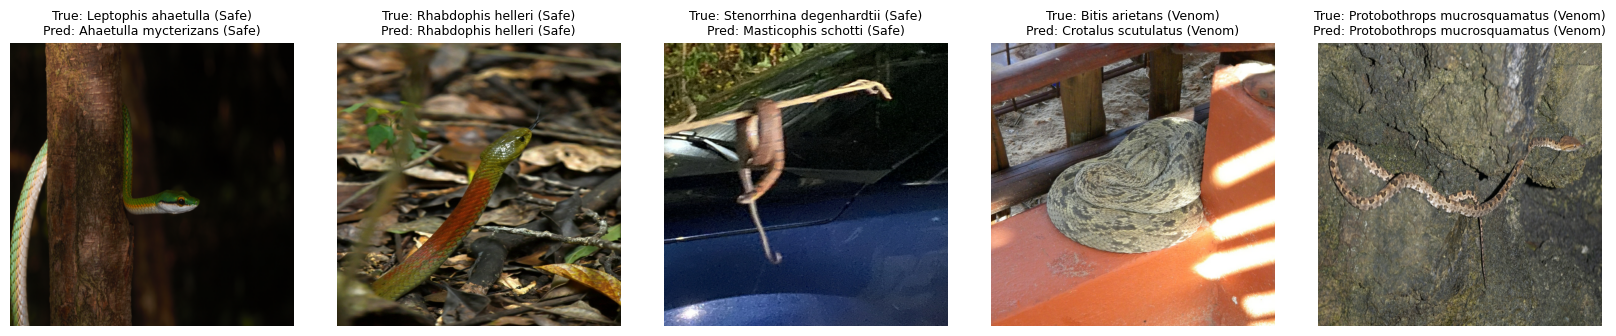

In [9]:
example_results_from_dataset(model, val_dataset, species_metadata, n_examples=5)

# Calculating scoring metrics

Function to tell if the species is venomous or not, based on encoded_id

# Plotting mistakes

In [10]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

def plot_per_class_recall_f1(results):
    y_true = results["y_species_true"]
    y_pred = results["y_species_pred"]

    report = classification_report(y_true, y_pred, output_dict=True)
    class_ids = sorted([int(c) for c in report.keys() if c.isdigit()])

    recalls = [report[str(c)]["recall"] for c in class_ids]
    f1s     = [report[str(c)]["f1-score"] for c in class_ids]

    plt.figure(figsize=(20,6))
    plt.bar(class_ids, recalls)
    plt.title("Per-Class Recall")
    plt.xlabel("Class ID")
    plt.ylabel("Recall")
    plt.show()

    plt.figure(figsize=(20,6))
    plt.bar(class_ids, f1s)
    plt.title("Per-Class F1-Score")
    plt.xlabel("Class ID")
    plt.ylabel("F1")
    plt.show()
import numpy as np

def get_top_confused_pairs(cm, species_names, top_k=20):
    """
    Returns the top most confused class pairs from a confusion matrix.
    
    Args:
        cm: confusion matrix (shape NxN)
        species_names: list mapping class_id -> species name
        top_k: how many confused pairs to return

    Returns:
        A list of dicts with:
            true_id, pred_id, true_name, pred_name, count
    """
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)  # remove correct predictions

    confusions = []

    # Find all non-zero misclassifications
    for true_cls in range(cm_no_diag.shape[0]):
        for pred_cls in range(cm_no_diag.shape[1]):
            count = cm_no_diag[true_cls, pred_cls]
            if count > 0:
                confusions.append((true_cls, pred_cls, count))

    # Sort by count descending
    confusions.sort(key=lambda x: x[2], reverse=True)

    # Build output list
    results = []
    for true_id, pred_id, count in confusions[:top_k]:
        results.append({
            "true_id": true_id,
            "pred_id": pred_id,
            "true_name": species_names[true_id],
            "pred_name": species_names[pred_id],
            "count": count
        })

    return results


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(results):
    y_true = results["y_species_true"]
    y_pred = results["y_species_pred"]

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, cmap='Blues')
    plt.title("Normalized Confusion Matrix")
    plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
plot_per_class_recall_f1(results_own_metrics)

In [ ]:
plot_confusion_matrix(results_own_metrics)